# Technical Validation


Author: Thiago Nascimento (thiago.nascimento@eawag.ch)

This notebook is part of the EStreams publication and was used to provide one step towards the technical validation used in the paper:


* Basin delineation validation
* E-OBS coverage
* Validation of meteorological forcing
* Validation of the number of reservoirs




Note that this code enables not only the replicability of the current database but also the extrapolation to new catchment areas. 
* Additionally, the user should download and insert the original raw-data in the folder of the same name prior to run this code. 
* The original third-party data used were not made avaialble in this repository due to redistribution and storage-space reasons.  

## Requirements
**Python:**

* Python>=3.6
* Jupyter
* Geopandas=0.10.2
* Pandas
* tqdm

Check the Github repository for an environment.yml (for conda environments) or requirements.txt (pip) file.

**Files:**

* estreams_boundaries.shp
* lamah_boundaries.shp
* mghydro_boundaries_AT00009
* riv_pfaf_2_MERIT_Hydro_v07_Basins_v01.shp. Available at: https://www.reachhydro.org/home/params/merit-basins (Last access: 23 November 2023)
* europe.shp
* estreams_network.xlsx
* estreams_timeseries_p.csv
* Files: CAMELS_GB_hydromet_timeseries_{station}_19701001-20150930.csv. Available at: https://doi.org/10.5285/8344e4f3-d2ea-44f5-8afa-86d2987543a9 (Last access 08 December 2023)
* Files: CAMELS_CH_obs_based_{station}.csv. Available at: https://doi.org/10.5281/zenodo.10010004 (Last access 08 December 2023)
* AtAgua_Agsup_ALB_NET_Project_PC.shp. Available at https://sniamb.apambiente.pt/content/geo-visualizador (Last access 08 February 2024)

**Directory:**

* Clone the GitHub directory locally
* ONLY update the "PATH" variable in the section "Configurations", with their relative path to the EStreams directory. 

## References
* Yamazaki, D. et al. A high-accuracy map of global terrain elevations. Geophys Res Lett 44, 5844–5853 (2017).

* Yamazaki, D. et al. MERIT Hydro: A High-Resolution Global Hydrography Map Based on Latest Topography Dataset. Water Resour Res 55, 5053–5073 (2019).

* Coxon, G., Addor, N., Bloomfield, J. P., Freer, J., Fry, M., Hannaford, J., Howden, N. J. K., Lane, R., Lewis, M., Robinson, E. L., Wagener, T., and Woods, R.: CAMELS-GB: hydrometeorological time series and landscape attributes for 671 catchments in Great Britain, Earth Syst. Sci. Data, 12, 2459–2483, https://doi.org/10.5194/essd-12-2459-2020, 2020.

* Coxon, G.; Addor, N.; Bloomfield, J.P.; Freer, J.; Fry, M.; Hannaford, J.; Howden, N.J.K.; Lane, R.; Lewis, M.; Robinson, E.L.; Wagener, T.; Woods, R. (2020). Catchment attributes and hydro-meteorological timeseries for 671 catchments across Great Britain (CAMELS-GB). NERC Environmental Information Data Centre. https://doi.org/10.5285/8344e4f3-d2ea-44f5-8afa-86d2987543a9

* Höge, M., Kauzlaric, M., Siber, R., Schönenberger, U., Horton, P., Schwanbeck, J., Floriancic, M. G., Viviroli, D., Wilhelm, S., Sikorska-Senoner, A. E., Addor, N., Brunner, M., Pool, S., Zappa, M., and Fenicia, F.: CAMELS-CH: hydro-meteorological time series and landscape attributes for 331 catchments in hydrologic Switzerland, Earth Syst. Sci. Data Discuss. [preprint], https://doi.org/10.5194/essd-2023-127, in review, 2023.

* Höge, M., Kauzlaric, M., Siber, R., Schönenberger, U., Horton, P., Schwanbeck, J., Floriancic, M. G., Viviroli, D., Wilhelm, S., Sikorska-Senoner, A. E., Addor, N., Brunner, M., Pool, S., Zappa, M., & Fenicia, F. (2023). Catchment attributes and hydro-meteorological time series for large-sample studies across hydrologic Switzerland (CAMELS-CH) (0.7) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.10010004

## License
* MERIT: Dual-license - CC-BY-NC 4.0 and ODbL 1.0. http://hydro.iis.u-tokyo.ac.jp/~yamadai/MERIT_DEM/index.html (Last access: 27 November 2023)

# Import modules

In [4]:
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from shapely.geometry import Point, Polygon
import matplotlib as mpl
import glob
import tqdm as tqdm
from utils.hydrology import count_geometries_in_polygons
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Configurations

In [2]:
# Only editable variable:
PATH = r"/Users/thiagomedeirosdonascimento/Library/CloudStorage/OneDrive-Personal/PhD/Eawag/Papers/Paper1_Database/Paper/"

# Non-editable variables:
PATH_OUTPUT = "results/"
os.chdir(PATH)

# Basin delineation validation
## Import data
### Catchment boundaries
* EStreams
* Lamah
* mghydro delineation

In [3]:
catchment_boundaries = gpd.read_file('data/shapefiles/estreams_catchments.shp')
catchment_boundaries

,id,area_km2,outlet_lat,outlet_lng,name,area_offic,area_calc,Code,basin_id,label_area,layer,path,geometry
0,DE01821,83,52.289000,9.085000,4723104,86.5,83.018,DE01821,DE01821,None,catchments_DE_NI_v04,C:/Users/nascimth/Documents/Thiago/Eawag/Pytho...,"POLYGON Z ((9.08958 52.29875 0.00000, 9.09208 ..."
1,DE01823,179,52.095000,9.377000,4572113,181,178.891,DE01823,DE01823,None,catchments_DE_NI_v04,C:/Users/nascimth/Documents/Thiago/Eawag/Pytho...,"POLYGON Z ((9.41125 52.09458 0.00000, 9.41125 ..."
2,DE01824,74,53.336000,8.926000,4948105,80,73.886,DE01824,DE01824,None,catchments_DE_NI_v04,C:/Users/nascimth/Documents/Thiago/Eawag/Pytho...,"POLYGON Z ((8.92458 53.38041 0.00000, 8.92791 ..."
3,DE01825,56,53.555000,9.071000,5986104,55,56.034,DE01825,DE01825,None,catchments_DE_NI_v04,C:/Users/nascimth/Documents/Thiago/Eawag/Pytho...,"POLYGON Z ((9.04041 53.60291 0.00000, 9.04291 ..."
4,DE01826,193,52.405000,9.986000,4854112,180,192.971,DE01826,DE01826,None,catchments_DE_NI_v04,C:/Users/nascimth/Documents/Thiago/Eawag/Pytho...,"POLYGON Z ((9.91708 52.35708 0.00000, 9.91624 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15180,NL00013,28900,51.827000,5.566000,Megen dorp,None,28900.000,NL00013,NL00013,4,Catchment_Boundaries_NL_Merge,C:\Users\nascimth\Documents\Thiago\Eawag\Pytho...,"POLYGON Z ((4.45041 49.91875 0.00000, 4.45041 ..."
15181,NL00015,148,51.812000,4.566000,Puttershoek,None,148.000,NL00015,NL00015,888,Catchment_Boundaries_NL_Merge,C:\Users\nascimth\Documents\Thiago\Eawag\Pytho...,"POLYGON Z ((4.49041 51.82958 0.00000, 4.49041 ..."
15182,NL00016,9500,51.350000,4.251000,Schaar van Ouden Doel,None,9500.000,NL00016,NL00016,4,Catchment_Boundaries_NL_Merge,C:\Users\nascimth\Documents\Thiago\Eawag\Pytho...,"POLYGON Z ((4.18958 51.29875 0.00000, 4.18958 ..."
15183,NL00017,21300,50.830000,5.697000,Sint Pieter noord,None,21300.000,NL00017,NL00017,4,Catchment_Boundaries_NL_Merge,C:\Users\nascimth\Documents\Thiago\Eawag\Pytho...,"POLYGON Z ((4.45041 49.91875 0.00000, 4.45041 ..."


In [4]:
catchment_boundaries_mghydro = gpd.read_file('data/shapefiles/lamah_boundaries.shp')
catchment_boundaries_mghydro

,id,area_km2,outlet_lat,outlet_lng,name,area_offic,layer,path,geometry
0,AT00001,"4,670",47.274,9.535,200014,4647.9,AT00001,C:/Users/nascimth/Documents/Thiago/Eawag/Pytho...,"POLYGON ((9.49708 47.21208, 9.49708 47.21291, ..."
1,AT00002,100,47.080,9.914,200048,102,AT00002,C:/Users/nascimth/Documents/Thiago/Eawag/Pytho...,"POLYGON ((9.93208 47.11625, 9.93708 47.11625, ..."
2,AT00003,534,47.133,9.848,231662,535.2,AT00003,C:/Users/nascimth/Documents/Thiago/Eawag/Pytho...,"POLYGON ((9.91958 47.11375, 9.92041 47.11375, ..."
3,AT00004,64,47.129,10.062,200592,66.59999999999999,AT00004,C:/Users/nascimth/Documents/Thiago/Eawag/Pytho...,"POLYGON ((10.17541 47.15791, 10.18124 47.15791..."
4,AT00005,71,47.151,9.803,200097,72.2,AT00005,C:/Users/nascimth/Documents/Thiago/Eawag/Pytho...,"POLYGON ((9.80041 47.15208, 9.80208 47.15208, ..."
...,...,...,...,...,...,...,...,...,...
1563,GB00005,24,50.650,-1.250,101005,24.31,GB00005,C:/Users/nascimth/Documents/Thiago/Eawag/Pytho...,"POLYGON ((-1.25458 50.65458, -1.25291 50.65458..."
1564,GB00004,31,50.690,-1.290,101002,30.61,GB00004,C:/Users/nascimth/Documents/Thiago/Eawag/Pytho...,"POLYGON ((-1.29125 50.69041, -1.28958 50.69041..."
1565,GB00003,160,58.480,-3.270,1001,158.18,GB00003,C:/Users/nascimth/Documents/Thiago/Eawag/Pytho...,"POLYGON ((-3.28958 58.50291, -3.28958 58.50291..."
1566,GB00002,532,57.360,-2.090,10003,532.29,GB00002,C:/Users/nascimth/Documents/Thiago/Eawag/Pytho...,"POLYGON ((-2.10625 57.37791, -2.10625 57.37708..."


In [5]:
AT00009_mghydro = gpd.read_file('data/shapefiles/mghydro_boundaries_AT00009.shp')
AT00009_mghydro

,gid,geometry
0,0,"POLYGON ((9.59208 47.20875, 9.59125 47.21292, ..."


## Merit-Hydro river network

In [6]:
river_net_EU_MERIT = gpd.read_file('data/shapefiles/riv_pfaf_2_MERIT_Hydro_v07_Basins_v01.shp')
river_net_EU_MERIT

,COMID,lengthkm,lengthdir,sinuosity,slope,uparea,order,strmDrop_t,slope_taud,NextDownID,maxup,up1,up2,up3,up4,geometry
0,21000001,9.079822,5.620153,1.615583,0.000220,382.604819,2,2.0,0.000220,21000054,2,21000002,21000011,0,0,"LINESTRING (5.88917 47.94917, 5.88833 47.94917..."
1,21000002,2.842653,1.826319,1.556494,0.001124,325.410126,2,3.2,0.001124,21000001,2,21000004,21000013,0,0,"LINESTRING (5.90667 47.99833, 5.90750 47.99833..."
2,21000003,20.918003,14.119143,1.481535,0.001484,415.960268,2,31.1,0.001484,21000055,2,21000006,21000009,0,0,"LINESTRING (6.04750 47.95083, 6.04833 47.95083..."
3,21000004,12.775680,6.218682,2.054403,0.000609,275.794567,2,7.8,0.000609,21000002,2,21000005,21000016,0,0,"LINESTRING (5.91667 48.01333, 5.91750 48.01333..."
4,21000005,3.535374,2.233011,1.583232,0.001892,171.981367,2,6.7,0.001892,21000004,2,21000014,21000015,0,0,"LINESTRING (5.99083 48.03917, 5.99167 48.03833..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393459,29123032,30.204422,21.486454,1.405743,0.005751,82.869595,1,173.4,0.005751,0,0,0,0,0,0,"LINESTRING (43.49000 12.80583, 43.49083 12.805..."
393460,29123033,10.813198,8.296287,1.303378,0.014205,65.406667,1,153.2,0.014205,29122956,0,0,0,0,0,"LINESTRING (44.46250 12.82500, 44.46167 12.825..."
393461,29123034,16.082080,9.903307,1.623910,0.011262,67.604187,1,180.7,0.011262,0,0,0,0,0,0,"LINESTRING (44.59833 12.81833, 44.59750 12.819..."
393462,29123035,1.327687,0.656550,2.022219,0.000000,36.423539,1,0.0,0.000000,0,0,0,0,0,0,"LINESTRING (45.07917 12.90917, 45.07833 12.908..."


In [7]:
# Now we dissolve the shapefile
river_net_EU_MERIT_dissolved = river_net_EU_MERIT.dissolve()

## Catchment areas from mghydro for Austria


In [8]:
# The final database presents the official source area and not the delineation from mghydro. 
# That is the reason why we need to check the data for those three countries from this separated file:

catchments_comparison = pd.read_excel("data/lamah_boundaries.xlsx")
catchments_comparison.set_index("id", inplace = True)
catchments_comparison.drop("path", axis = 1, inplace = True)

catchments_comparison.columns = ["area_mghydro", "lat", "lon", "name", "area_official", "code", "per_diff"]
catchments_comparison.index.name = "new_code"

catchments_comparison.area_official.replace(0, np.nan, inplace = True)

catchments_comparison["per_diff_abs"] = abs(catchments_comparison["per_diff"])

catchments_comparison

,area_mghydro,lat,lon,name,area_official,code,per_diff,per_diff_abs
new_code,,,,,,,,
AT00001,4670,47.274,9.535,200014,4647.9,AT00001,0.475484,0.475484
AT00002,100,47.080,9.914,200048,102.0,AT00002,-1.960784,1.960784
AT00003,534,47.133,9.848,231662,535.2,AT00003,-0.224215,0.224215
AT00004,64,47.129,10.062,200592,66.6,AT00004,-3.903904,3.903904
AT00005,71,47.151,9.803,200097,72.2,AT00005,-1.662050,1.662050
...,...,...,...,...,...,...,...,...
AT00595,380,46.885,14.866,213082,380.2,AT00595,-0.052604,0.052604
AT00596,56,46.841,14.835,213314,55.9,AT00596,0.178891,0.178891
AT00597,713,46.784,14.836,213371,715.6,AT00597,-0.363331,0.363331


In [9]:
above10 = catchments_comparison[catchments_comparison.per_diff_abs > 10][catchments_comparison.area_official > 0]
above10

/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_25758/2918239238.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  above10 = catchments_comparison[catchments_comparison.per_diff_abs > 10][catchments_comparison.area_official > 0]


,area_mghydro,lat,lon,name,area_official,code,per_diff,per_diff_abs
new_code,,,,,,,,
AT00009,4680,47.260,9.579,200147,1281.0,AT00009,265.339578,265.339578
AT00011,1300,47.284,9.594,200527,25.2,AT00011,5058.730159,5058.730159
AT00012,1310,47.306,9.579,200162,39.1,AT00012,3250.383632,3250.383632
AT00018,3,47.435,9.696,200220,77.5,AT00018,-96.129032,96.129032
AT00023,235,47.371,9.896,200493,14.1,AT00023,1566.666667,1566.666667
AT00025,16,47.472,10.022,200584,13.7,AT00025,16.788321,16.788321
AT00030,6,47.536,9.745,200345,6.8,AT00030,-11.764706,11.764706
AT00040,263,47.390,11.264,201095,203.6,AT00040,29.174853,29.174853
AT00044,2140,46.937,10.490,201160,107.8,AT00044,1885.157699,1885.157699


In [10]:
print("Catchemnts with differences above 10%: ", int(len(above10)))

Catchemnts with differences above 10%:  60


In [11]:
above10_above100area = catchments_comparison[catchments_comparison.per_diff_abs > 10][catchments_comparison.area_official > 100]
above10_above100area

/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_25758/780520303.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  above10_above100area = catchments_comparison[catchments_comparison.per_diff_abs > 10][catchments_comparison.area_official > 100]


,area_mghydro,lat,lon,name,area_official,code,per_diff,per_diff_abs
new_code,,,,,,,,
AT00009,4680,47.260,9.579,200147,1281.0,AT00009,265.339578,265.339578
AT00040,263,47.390,11.264,201095,203.6,AT00040,29.174853,29.174853
AT00044,2140,46.937,10.490,201160,107.8,AT00044,1885.157699,1885.157699
AT00144,756,47.585,12.698,203505,107.4,AT00144,603.910615,603.910615
AT00159,220,48.131,13.146,206078,188.8,AT00159,16.525424,16.525424
AT00243,173,47.381,13.429,203711,134.5,AT00243,28.624535,28.624535
AT00292,142,47.860,15.031,209551,117.9,AT00292,20.441052,20.441052
AT00361,1140,48.140,16.473,208157,1028.9,AT00361,10.797940,10.797940
AT00362,1140,48.141,16.476,208199,112.8,AT00362,910.638298,910.638298


In [12]:
print("Catchemnts with differences above 10% and areas above 100km2: ", int(len(above10_above100area)))

Catchemnts with differences above 10% and areas above 100km2:  21


In [13]:
catchments_comparison.loc[:, ["area_official", "area_mghydro"]].corr()

,area_official,area_mghydro
area_official,1.000000,0.999016
area_mghydro,0.999016,1.000000


## Plots

In [14]:
# Create a GeoDataFrame with a geometry column containing Point geometries
geometry = [Point(xy) for xy in zip(catchments_comparison['lon'], catchments_comparison['lat'])]
geo_df = gpd.GeoDataFrame(catchments_comparison, geometry=geometry, crs='EPSG:4326')  # Assuming WGS84 CRS

### Plot 1, Not logarithmic

/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_25758/3551569527.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axin.set_yticklabels(axin.get_yticks().astype(int), rotation=360)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


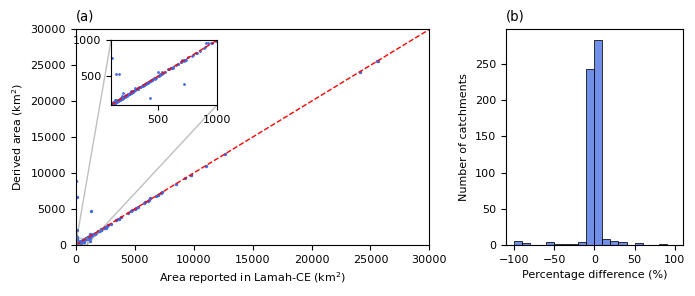

In [16]:
plt.rcParams.update({'font.size': 8})  # Change the 12 to your desired font size

fig, axs = plt.subplots(1, 2, figsize=(7, 3),  gridspec_kw={'width_ratios': [2, 1]})

axs[0].scatter(catchments_comparison["area_official"],catchments_comparison["area_mghydro"], s = 2, color='royalblue')

axin = axs[0].inset_axes([0.1, 0.65, 0.3, 0.3]) 
axin.scatter(catchments_comparison["area_official"],catchments_comparison["area_mghydro"], s=1, color='royalblue')

axs[0].set_xlim(0, 30000)
axs[0].set_ylim(0, 30000)
axs[0].set_ylabel("Derived area ($\mathrm{km}^2$)")
axs[0].set_xlabel("Area reported in Lamah-CE ($\mathrm{km}^2$)")

axin.set_xlim(100, 1000)
axin.set_ylim(100, 1000)

axs[0].axline((0, 0), slope=1, color='red', linestyle='--', linewidth = 1)
axin.axline((0, 0), slope=1, color='red', linestyle='--', linewidth = 1)

axin.set_yticklabels(axin.get_yticks().astype(int), rotation=360)


axs[0].indicate_inset_zoom(axin)


# Plotting the histogram
# Create a histogram with custom bin edges
bin_edges = [ -100, -90,-80, -70, -60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
sns.histplot(catchments_comparison.per_diff, bins=bin_edges, kde=False, color='royalblue', ax=axs[1])
axs[1].set_ylabel("Number of catchments")
axs[1].set_xlabel("Percentage difference (%)")

# Title and labels
axs[0].set_title('(a)', loc="left")
axs[1].set_title('(b)', loc="left")

# Legend for the second subplot
axs[1].legend(frameon=False)

fig.tight_layout()

fig.savefig('results/areas_comparison.png', dpi=300,  bbox_inches='tight')

### Plot 1, Logarithmic scale

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


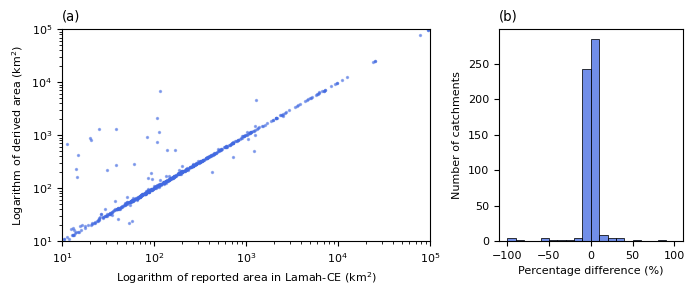

In [17]:
plt.rcParams.update({'font.size': 8})  # Change the 12 to your desired font size

fig, axs = plt.subplots(1, 2, figsize=(7, 3),  gridspec_kw={'width_ratios': [2, 1]})

axs[0].scatter(catchments_comparison["area_official"],catchments_comparison["area_mghydro"], s = 2, color='royalblue', 
              alpha = 0.5)

axs[0].set_xlim(10, 100000)
axs[0].set_ylim(10, 100000)
axs[0].set_ylabel("Logarithm of derived area ($\mathrm{km}^2$)")
axs[0].set_xlabel("Logarithm of reported area in Lamah-CE ($\mathrm{km}^2$)")

axs[0].set_xscale('log')  # Set x-axis to log scale
axs[0].set_yscale('log')  # Set y-axis to log scale

# Plotting the histogram
# Create a histogram with custom bin edges
bin_edges = [ -100, -90,-80, -70, -60, -50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
sns.histplot(catchments_comparison.per_diff, bins=bin_edges, kde=False, color='royalblue', ax=axs[1])
axs[1].set_ylabel("Number of catchments")
axs[1].set_xlabel("Percentage difference (%)")

# Title and labels
axs[0].set_title('(a)', loc="left")
axs[1].set_title('(b)', loc="left")

# Legend for the second subplot
axs[1].legend(frameon=False)

fig.tight_layout()

fig.savefig('results/areas_comparison_log.png', dpi=300,  bbox_inches='tight')

### Plot 2

In [18]:
catchment1 = catchment_boundaries[catchment_boundaries.id == "AT00009"]
catchment1

,id,area_km2,outlet_lat,outlet_lng,name,area_offic,area_calc,Code,basin_id,label_area,layer,path,geometry
14542,AT00009,1281.796010374236,47.26,9.579,Gisingen,1281,1281.796,AT00009,AT00009,0,None,None,"POLYGON Z ((10.11095 46.89437 0.00000, 10.1122..."


In [19]:
catchment1_mghydro = catchment_boundaries_mghydro[catchment_boundaries_mghydro.id == "AT00009"]
catchment1_mghydro

,id,area_km2,outlet_lat,outlet_lng,name,area_offic,layer,path,geometry
8,AT00009,"4,680",47.26,9.579,200147,1281,AT00009,C:/Users/nascimth/Documents/Thiago/Eawag/Pytho...,"POLYGON ((9.49708 47.21208, 9.49708 47.21291, ..."


In [20]:
gauge1 = geo_df[geo_df.index == "AT00009"]
gauge1

,area_mghydro,lat,lon,name,area_official,code,per_diff,per_diff_abs,geometry
new_code,,,,,,,,,
AT00009,4680,47.26,9.579,200147,1281.0,AT00009,265.339578,265.339578,POINT (9.57900 47.26000)


In [21]:
# Perform the spatial clip of the river network (faster processing for plot)

# We also set a buffer to have the network beyond the boundaries
buffer_distance = 0.01  # Adjust the buffer distance as needed
buffered_1 = catchment1.geometry.buffer(buffer_distance)
buffered_2 = catchment1_mghydro.geometry.buffer(buffer_distance)

rivers_1 = gpd.clip(river_net_EU_MERIT_dissolved, buffered_1)

rivers_2 = gpd.clip(river_net_EU_MERIT_dissolved, buffered_2)

/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_25758/1311748261.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffered_1 = catchment1.geometry.buffer(buffer_distance)
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_25758/1311748261.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buffered_2 = catchment1_mghydro.geometry.buffer(buffer_distance)


/Users/thiagomedeirosdonascimento/anaconda3/envs/eawag/lib/python3.10/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/Users/thiagomedeirosdonascimento/anaconda3/envs/eawag/lib/python3.10/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/Users/thiagomedeirosdonascimento/anaconda3/envs/eawag/lib/python3.10/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


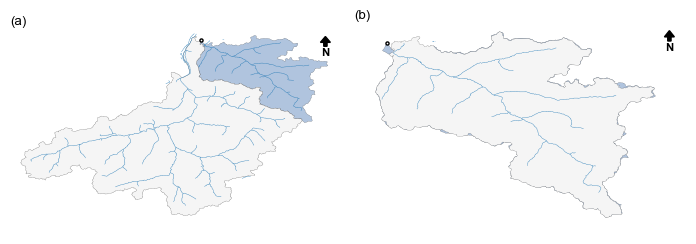

In [22]:
# Set font properties using rcParams
mpl.rcParams['font.family'] = 'arial'  # Change the font family
mpl.rcParams['font.weight'] = 'normal'  # Change font weight (e.g., 'bold', 'normal')
mpl.rcParams['axes.labelweight'] = 'normal'  # Change label font weight (e.g., 'bold', 'normal')

fig, axs = plt.subplots(1, 2, figsize=(7, 3),  gridspec_kw={'width_ratios': [1, 1]})

###1:
# Set the background color to white
axs[0].set_facecolor('white')
# Plot the shapefile with white facecolor and black boundaries
catchment1.plot(ax=axs[0], facecolor='lightsteelblue', edgecolor='black', linewidth=0.1)
catchment1_mghydro.plot(ax=axs[0], facecolor='whitesmoke', edgecolor='black', linewidth=0.1)


rivers_1.plot(ax=axs[0], linewidth=0.25)
rivers_2.plot(ax=axs[0], linewidth=0.25)

gauge1.plot(ax=axs[0], marker='o', color='white', markersize=5, edgecolor='black')

minx, miny, maxx, maxy = 8.6, 46.3, 10.3, 47.3
axs[0].set_xlim(minx, maxx) 
axs[0].set_ylim(miny, maxy)  

axs[0].set_axis_off()  # Turn off both x-axis and y-axis

axs[0].set_aspect('equal')  # Adjust aspect ratio as needed
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].spines['bottom'].set_visible(False)
axs[0].spines['left'].set_visible(False)

# Title and (a) label for the first subplot
axs[0].set_title('(a)', loc="left")


# Set the background color to white
axs[1].set_facecolor('white')
# Plot the shapefile with white facecolor and black boundaries
catchment1.plot(ax=axs[1], facecolor='lightsteelblue', edgecolor='black', linewidth=0.1)
AT00009_mghydro.plot(ax=axs[1], facecolor='whitesmoke', edgecolor='black', linewidth=0.1)


rivers_1.plot(ax=axs[1], linewidth=0.25)

gauge1.plot(ax=axs[1], marker='o', color='white', markersize=5, edgecolor='black')

minx, miny, maxx, maxy = 9.5, 46.8, 10.3, 47.3
axs[1].set_xlim(minx, maxx) 
axs[1].set_ylim(miny, maxy)  


axs[1].set_axis_off()  # Turn off both x-axis and y-axis

axs[1].set_aspect('equal')  # Adjust aspect ratio as needed
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)
axs[1].spines['left'].set_visible(False)

# Title and (a) label for the first subplot
axs[1].set_title('(b)', loc="left")

# Add a north arrow to the first subplot (axs[0])
arrow_length = 0.02
arrow_style = dict(facecolor='black', edgecolor='black', width=0.01, head_width=0.03, head_length=0.03)

# Add the arrow to the first subplot
axs[0].arrow(0.95, 0.95 - arrow_length, 0, arrow_length, **arrow_style, transform=axs[0].transAxes)

# Repeat the same for the second subplot
axs[1].arrow(0.95, 0.95 - arrow_length, 0, arrow_length, **arrow_style, transform=axs[1].transAxes)

# Add 'N' text to the first subplot
axs[0].text(0.95, 0.95 - arrow_length - 0.03, 'N', ha='center', va='center', fontsize=8, fontweight='bold', color='black', transform=axs[0].transAxes)
axs[1].text(0.95, 0.95 - arrow_length - 0.03, 'N', ha='center', va='center', fontsize=8, fontweight='bold', color='black', transform=axs[1].transAxes)

fig.patch.set_facecolor('none')


#plt.rcParams.update({'font.size': 8})  # Change 18 to your desired font size

fig.tight_layout()

# Save or display the plot
#plt.show()
fig.savefig('results/fig2_comparison_areas.png', dpi=300,  bbox_inches='tight')

# E-OBS coverage

## Import data
### Catchment boundaries

In [23]:
catchment_boundaries = gpd.read_file('data/shapefiles/estreams_catchments.shp')
catchment_boundaries

,id,area_km2,outlet_lat,outlet_lng,name,area_offic,area_calc,Code,basin_id,label_area,layer,path,geometry
0,DE01821,83,52.289000,9.085000,4723104,86.5,83.018,DE01821,DE01821,None,catchments_DE_NI_v04,C:/Users/nascimth/Documents/Thiago/Eawag/Pytho...,"POLYGON Z ((9.08958 52.29875 0.00000, 9.09208 ..."
1,DE01823,179,52.095000,9.377000,4572113,181,178.891,DE01823,DE01823,None,catchments_DE_NI_v04,C:/Users/nascimth/Documents/Thiago/Eawag/Pytho...,"POLYGON Z ((9.41125 52.09458 0.00000, 9.41125 ..."
2,DE01824,74,53.336000,8.926000,4948105,80,73.886,DE01824,DE01824,None,catchments_DE_NI_v04,C:/Users/nascimth/Documents/Thiago/Eawag/Pytho...,"POLYGON Z ((8.92458 53.38041 0.00000, 8.92791 ..."
3,DE01825,56,53.555000,9.071000,5986104,55,56.034,DE01825,DE01825,None,catchments_DE_NI_v04,C:/Users/nascimth/Documents/Thiago/Eawag/Pytho...,"POLYGON Z ((9.04041 53.60291 0.00000, 9.04291 ..."
4,DE01826,193,52.405000,9.986000,4854112,180,192.971,DE01826,DE01826,None,catchments_DE_NI_v04,C:/Users/nascimth/Documents/Thiago/Eawag/Pytho...,"POLYGON Z ((9.91708 52.35708 0.00000, 9.91624 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15180,NL00013,28900,51.827000,5.566000,Megen dorp,None,28900.000,NL00013,NL00013,4,Catchment_Boundaries_NL_Merge,C:\Users\nascimth\Documents\Thiago\Eawag\Pytho...,"POLYGON Z ((4.45041 49.91875 0.00000, 4.45041 ..."
15181,NL00015,148,51.812000,4.566000,Puttershoek,None,148.000,NL00015,NL00015,888,Catchment_Boundaries_NL_Merge,C:\Users\nascimth\Documents\Thiago\Eawag\Pytho...,"POLYGON Z ((4.49041 51.82958 0.00000, 4.49041 ..."
15182,NL00016,9500,51.350000,4.251000,Schaar van Ouden Doel,None,9500.000,NL00016,NL00016,4,Catchment_Boundaries_NL_Merge,C:\Users\nascimth\Documents\Thiago\Eawag\Pytho...,"POLYGON Z ((4.18958 51.29875 0.00000, 4.18958 ..."
15183,NL00017,21300,50.830000,5.697000,Sint Pieter noord,None,21300.000,NL00017,NL00017,4,Catchment_Boundaries_NL_Merge,C:\Users\nascimth\Documents\Thiago\Eawag\Pytho...,"POLYGON Z ((4.45041 49.91875 0.00000, 4.45041 ..."


In [24]:
print("The total number of catchments to be processed are:", len(catchment_boundaries))

The total number of catchments to be processed are: 15185


### Study area shapefile

In [25]:
shapefile_path = "data/shapefiles/europe.shp"
europe = gpd.read_file(shapefile_path)

### E-OBS stations

In [26]:
# Check the files in the subdirectory:
filenames = glob.glob("data/eobs_stations/*.txt")
print("Number of files:", len(filenames))
print("First file:", filenames[0])

Number of files: 8
First file: data/eobs_stations/stations_info_qq_v28.0e.txt


In [27]:
filenames

['data/eobs_stations/stations_info_qq_v28.0e.txt',
 'data/eobs_stations/stations_info_pp_v28.0e.txt',
 'data/eobs_stations/stations_info_tg_v28.0e.txt',
 'data/eobs_stations/stations_info_tx_v28.0e.txt',
 'data/eobs_stations/stations_info_fg_v28.0e.txt',
 'data/eobs_stations/stations_info_rr_v28.0e.txt',
 'data/eobs_stations/stations_info_tn_v28.0e.txt',
 'data/eobs_stations/stations_info_hu_v28.0e.txt']

In [28]:
# Here we analyse the precipitation gauges:
filename = filenames[5]

# Use read_csv with the '|' delimiter
eobs_stations = pd.read_csv(filename, delimiter='|', encoding='latin1')
eobs_stations.columns = ['STATION', 'NAME','COUNTRY', 'LAT', 'LON', 'ELEV',
       'START', 'STOP']
eobs_stations

,STATION,NAME,COUNTRY,LAT,LON,ELEV,START,STOP
0,1,Vaexjoe,SWEDEN,56.87,14.80,166.0,1950-01-01,2019-12-31
1,2,Falun,SWEDEN,60.62,15.62,160.0,1950-01-01,2023-06-30
2,3,Stensele,SWEDEN,65.07,17.15,325.0,1950-01-01,2004-12-31
3,4,Linkoeping,SWEDEN,58.40,15.53,93.0,1950-01-01,2023-06-30
4,5,Linkoeping-Malmslaett,SWEDEN,58.40,15.53,93.0,1950-01-01,2023-06-30
...,...,...,...,...,...,...,...,...
18689,26309,KLOEFTA,NORWAY,60.07,11.13,162.0,1956-01-01,2023-06-30
18690,26310,JESSHEIM,NORWAY,60.15,11.18,203.0,1956-01-01,2023-06-30
18691,26317,EIKELANDSOSEN,NORWAY,60.25,5.74,82.0,2023-04-01,2023-06-30
18692,26318,MIDTBOTN,NORWAY,59.92,6.18,827.0,2023-04-01,2023-06-30


In [29]:
# Convert the DataFrame to a GeoDataFrame
geometry = [Point(lon, lat) for lon, lat in zip(eobs_stations['LON'], eobs_stations['LAT'])]
eobs_stations_geo_df = gpd.GeoDataFrame(eobs_stations, geometry=geometry)

# Optionally, set the coordinate reference system (CRS)
# For example, using EPSG:4326 for WGS 84
eobs_stations_geo_df.crs = 'EPSG:4326'

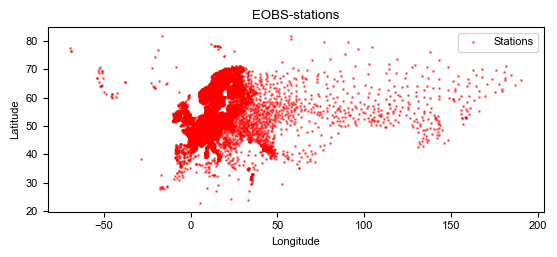

In [30]:
# Just to check:
eobs_stations_geo_df.plot(ax=plt.gca(), marker='o', alpha=0.5, color='red', markersize=1, label='Stations')

# Add labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('EOBS-stations')

# Add a legend
plt.legend()

# Show the plot
plt.show()

## Reproject to projected coordinates system
* We need to reproject our geodataframes to a projected coordinate system (in meters) in order to provide the buffer correctly.

In [31]:
# Here you can check the crs of the datasets:
print("CRS of catchment_boundaries:", catchment_boundaries.crs)
print("CRS of stations:", geo_df.crs)

CRS of catchment_boundaries: epsg:4326
CRS of stations: EPSG:4326


In [ ]:
# Define the target CRS to ETRS89 LAEA (3035)
target_crs = 'EPSG:3035'  

# Reproject the GeoDataFrame to the target CRS
eobs_stations_geo_df_reprojected = eobs_stations_geo_df.to_crs(target_crs)
catchment_boundaries_reprojected = catchment_boundaries.to_crs(target_crs)

## Computation

In [58]:
subset_catchment = catchment_boundaries_reprojected.copy()

In [59]:
# First we make a buffer of 10 km around the catchment shapefiles (this code may take a while to run)
buffer_distance = 10000
buffered_catchment_boundaries_reprojected = subset_catchment.copy()
buffered_catchment_boundaries_reprojected['geometry'] = subset_catchment['geometry'].buffer(buffer_distance)

In [68]:
# First we create an empty dataframe:
num_stations = pd.DataFrame()

# Here we use utils.hydrology.count_geometries_in_polygons function
num_stations["num_prec_stations"] = count_geometries_in_polygons(eobs_stations_geo_df_reprojected, 
                                                                 buffered_catchment_boundaries_reprojected, "basin_id", 
                                                                 new_column="dam_num")

In [69]:
num_stations["area"] = buffered_catchment_boundaries_reprojected.set_index("basin_id", inplace = False).area_calc
num_stations["density"] = num_stations["num_prec_stations"] / num_stations["area"]
num_stations

,num_prec_stations,area,density
basin_id,,,
DE00001,32.0,1254.621,0.025506
DE00002,51.0,1794.603,0.028419
DE00003,71.0,2295.630,0.030928
DE00004,16.0,289.199,0.055325
DE00005,120.0,5374.636,0.022327
...,...,...,...
HU00042,0.0,25.000,0.000000
HU00043,1.0,3960.000,0.000253
HU00044,1.0,1680.000,0.000595


In [70]:
num_stations[num_stations.num_prec_stations<1]

,num_prec_stations,area,density
basin_id,,,
ITGR017,0.0,81.405,0.0
ITIS007,0.0,65.358,0.0
ITIS026,0.0,337.880,0.0
ITIS029,0.0,151.804,0.0
ITIS030,0.0,71.395,0.0
...,...,...,...
HU00025,0.0,4330.000,0.0
HU00026,0.0,3200.000,0.0
HU00030,0.0,257.000,0.0


In [78]:
# Export the analysis:
num_stations.to_csv(PATH_OUTPUT+"/estreams_meteorology_density.csv")

In [71]:
print("The number of catchments with less than 1 gauge inside their catchment area is:", 
      len(num_stations[num_stations.num_prec_stations<1]))

The number of catchments with less than 1 gauge inside their catchment area is: 2257


## Plot:

The World Meteorological Organisation(WMO) recommends a threshold of one station per 575 km2 for the interior plane and undulating areas.

In [72]:
# Calculate the data and set the threshold
data = num_stations.density * 575
threshold = 1

/Users/thiagomedeirosdonascimento/anaconda3/envs/eawag/lib/python3.10/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


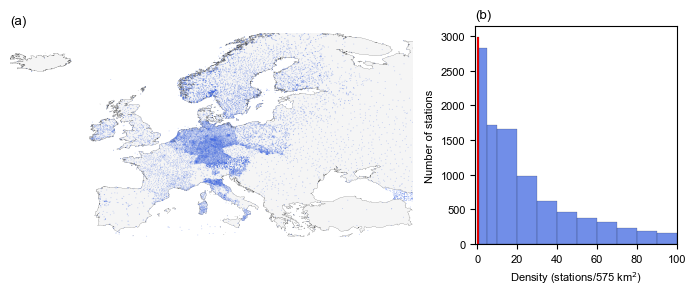

In [75]:
# Set font properties using rcParams
mpl.rcParams['font.family'] = 'arial'  # Change the font family
mpl.rcParams['font.weight'] = 'normal'  # Change font weight (e.g., 'bold', 'normal')
mpl.rcParams['axes.labelweight'] = 'bold'  # Change label font weight (e.g., 'bold', 'normal')

fig, axs = plt.subplots(1, 2, figsize=(7, 3),  gridspec_kw={'width_ratios': [2, 1]})

###1:
# Set the background color to white
axs[0].set_facecolor('white')
# Plot the shapefile with white facecolor and black boundaries
europe.plot(ax=axs[0], facecolor='whitesmoke', edgecolor='black', linewidth=0.1)
axs[0].set_xlim(-24, 45) 
axs[0].set_ylim(35, 70)  

eobs_stations_geo_df.plot(ax=axs[0], marker='o', alpha=0.3, color='royalblue', markersize=0.5, 
                          label='Stations', edgecolor='none')

axs[0].set_axis_off()  # Turn off both x-axis and y-axis

axs[0].set_aspect('equal')  # Adjust aspect ratio as needed
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].spines['bottom'].set_visible(False)
axs[0].spines['left'].set_visible(False)

# Title and (a) label for the first subplot
axs[0].set_title('(a)', loc="left")

# Plotting the histogram
bin_edges = [0, 1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
hist = sns.histplot(data, bins=bin_edges, kde=False, color='royalblue', ax=axs[1])

# Customize the color of the first bar
hist.patches[0].set_fc('red')

axs[1].set_xlim(-1, 100)  # Use set_ylim to set the y-axis limits

# Set labels and title with font size
axs[1].set_xlabel('Density (stations/575 km$^2$)', fontweight='normal')
axs[1].set_ylabel('Number of stations', fontweight='normal')


# Title and (a) label for the first subplot
axs[1].set_title('(b)', loc="left")
# Legend for the second subplot
axs[1].legend(frameon=False)

# Set the figure's background color to 'none'
fig.patch.set_facecolor('none')

plt.rcParams.update({'font.size': 8})  # Change 18 to your desired font size

fig.tight_layout()

# Save or display the plot
#plt.show()
fig.savefig('results/figdensityeobs.png', dpi=300,  bbox_inches='tight')

# Validation of meteorological forcing

## Network information

In [4]:
network_EU = pd.read_excel("data/streamflow/estreams_gauging_stations.xlsx")
network_EU.set_index("new_code", inplace = True)

network_EU

,code,name,river,area,elev,lon,lat,country,degimpact,lake,num_reservoir,RE,remark,region
new_code,,,,,,,,,,,,,,
AT00001,200014,Bangs,Rhein,4647.9,420,9.534835,47.273748,AT,s,NaN,NaN,NaN,NaN,NaN
AT00002,200048,Schruns (Vonbunweg),Litz,102.0,673,9.913677,47.080301,AT,l,NaN,NaN,NaN,NaN,NaN
AT00003,231662,Loruens-Aeule,Ill,535.2,579,9.847765,47.132821,AT,s,NaN,NaN,NaN,NaN,NaN
AT00004,200592,Kloesterle (OEBB),Alfenz,66.6,1014,10.061843,47.128994,AT,s,NaN,NaN,NaN,NaN,NaN
AT00005,200097,Buers (Bruecke L82),Alvier,72.2,564,9.802668,47.150770,AT,s,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DE02106,5752400000,Hachelbich,Wipper,524.0,NaN,10.973285,51.347098,DE,NaN,NaN,NaN,NaN,NaN,TH
DE02107,5752500000,Bleicherode,Bode,104.0,NaN,10.592766,51.450407,DE,NaN,NaN,NaN,NaN,NaN,TH
DE02108,5754000000,Sundhausen,Helme,200.6,NaN,10.809725,51.467735,DE,NaN,NaN,NaN,NaN,NaN,TH


In [5]:
# Here we subset only the Swiss data:
network_CH = network_EU[network_EU.country == "CH"]
network_CH

,code,name,river,area,elev,lon,lat,country,degimpact,lake,num_reservoir,RE,remark,region
new_code,,,,,,,,,,,,,,
CH00001,2009,Porte_du_Scex,Rhône,5239.4,377,6.89,46.35,CH,NaN,NaN,32.0,NaN,NaN,NaN
CH00002,2011,Sion,Rhône,3372.4,499,7.36,46.22,CH,NaN,NaN,20.0,NaN,NaN,NaN
CH00003,2016,Brugg,Aare,11681.3,341,8.19,47.48,CH,NaN,NaN,18.0,NaN,NaN,NaN
CH00004,2018,Mellingen,Reuss,3385.8,349,8.27,47.42,CH,NaN,NaN,11.0,NaN,NaN,NaN
CH00005,2019,Brienzwiler,Aare,555.2,587,8.09,46.75,CH,NaN,NaN,7.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CH00294,6007,Candoglia,Fiume_Toce,1531.4,198,8.42,45.97,CH,NaN,NaN,1.0,NaN,NaN,NaN
CH00295,6008,Gravellona,Torrente_Strona,229.7,211,8.43,45.93,CH,NaN,NaN,0.0,NaN,NaN,NaN
CH00296,6009,Santino,Torrente_San_Bernardino,121.6,254,8.53,45.96,CH,NaN,NaN,0.0,NaN,NaN,NaN


In [6]:
# Here we subset only the GB data:
network_GB = network_EU[network_EU.country == "GB"]
network_GB

,code,name,river,area,elev,lon,lat,country,degimpact,lake,num_reservoir,RE,remark,region
new_code,,,,,,,,,,,,,,
GB00001,10002,Ugie at Inverugie,Ugie at Inverugie,325.72,8.5,-1.83,57.53,GB,NaN,NaN,0.0,NaN,NaN,NaN
GB00002,10003,Ythan at Ellon,Ythan at Ellon,532.29,3.8,-2.09,57.36,GB,NaN,NaN,0.0,NaN,NaN,NaN
GB00003,1001,Wick at Tarroul,Wick at Tarroul,158.18,13,-3.27,58.48,GB,NaN,NaN,1.0,NaN,NaN,NaN
GB00004,101002,Medina at Shide,Medina at Shide,30.61,10.4,-1.29,50.69,GB,NaN,NaN,0.0,NaN,NaN,NaN
GB00005,101005,Eastern Yar at Budbridge,Eastern Yar at Budbridge,24.31,17.2,-1.25,50.65,GB,NaN,NaN,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GB00667,95001,Inver at Little Assynt,Inver at Little Assynt,138.47,60.3,-5.15,58.17,GB,NaN,NaN,0.0,NaN,NaN,NaN
GB00668,96001,Halladale at Halladale,Halladale at Halladale,193.72,23.2,-3.90,58.48,GB,NaN,NaN,0.0,NaN,NaN,NaN
GB00669,96002,Naver at Apigill,Naver at Apigill,474.01,5.1,-4.21,58.48,GB,NaN,NaN,0.0,NaN,NaN,NaN


## Eobs

In [8]:
timeseries_P_eobs = pd.read_csv("data/meteorology/estreams_meteorology_precipitation.csv", index_col=0)
timeseries_P_eobs.index = pd.to_datetime(timeseries_P_eobs.index)
timeseries_P_eobs.index.name = "dates"
timeseries_P_eobs

,AT00001,AT00002,AT00003,AT00004,AT00005,AT00006,AT00007,AT00008,AT00009,AT00010,...,UAGR012,UAGR013,UAGR014,UAGR015,UAGR016,UAGR017,UAGR018,UAGR019,UAGR020,UAGR021
dates,,,,,,,,,,,,,,,,,,,,,
1950-01-01,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00,...,0.00,0.01,0.01,0.00,0.00,2.79,2.9,3.73,0.01,0.00
1950-01-02,17.16,22.31,20.57,20.7,24.77,23.94,22.48,24.0,22.64,23.95,...,0.44,0.60,0.43,0.00,0.00,0.00,0.0,0.00,0.00,0.00
1950-01-03,25.71,21.56,22.79,18.8,27.59,23.36,24.06,27.4,24.41,19.97,...,1.75,1.61,1.77,0.14,1.35,2.86,2.6,2.40,5.19,1.78
1950-01-04,30.63,37.41,35.76,35.8,36.43,38.71,36.85,33.5,36.48,36.50,...,0.81,1.04,0.78,0.08,0.00,8.54,8.4,8.01,0.00,0.00
1950-01-05,0.07,1.97,1.38,2.7,0.12,1.12,1.08,0.0,0.97,0.78,...,1.04,1.06,1.00,0.00,0.64,1.47,1.5,2.00,0.00,2.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,0.05,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00,...,4.37,4.38,4.37,1.46,2.19,NaN,NaN,NaN,NaN,NaN
2022-12-28,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00,...,0.63,0.82,0.63,0.00,0.00,NaN,NaN,NaN,NaN,NaN
2022-12-29,1.64,1.08,0.88,0.9,1.50,1.95,1.22,1.5,1.25,3.57,...,1.09,1.44,1.09,0.00,0.00,NaN,NaN,NaN,NaN,NaN


## Camels-CH

In [9]:
# First we can check our files within the folder:
path ='data/meteorology/camelsch'
filenames = glob.glob(path + "/*.csv")
len(filenames)

331

In [12]:
# Now we read the data:
i = 0
timeseries_P_camelsch = pd.DataFrame(index = pd.date_range('01-01-1981','12-31-2022', freq='D'))

#### The tqdm module is useful for checking the progress bar of the loop.
for filename in tqdm.tqdm(filenames):
    # First we read our time-series:
    data = pd.read_csv(filename, encoding='latin-1', engine='python', skiprows = 0, delimiter = ";", usecols = [0, 4])

    # We define new column names:
    names = ['dates', 'P']
    data.columns = names

    # Convert our column of dates to datetime format:
    data["dates"] = pd.to_datetime(data["dates"], format='%Y-%m-%d')

    # Here we can set the index as the dates column:
    data.set_index("dates", inplace = True)

    # First we can retrieve the station name:
    namestation = os.path.basename(filename)
    namestation = namestation.split("_", 5)[4]
    namestation = namestation.replace(".csv", "")
    timeseries_P_camelsch.loc[:, int(namestation)] = data.P

 30%|████████████▌                             | 99/331 [00:02<00:05, 41.47it/s]/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1142641129.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsch.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1142641129.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsch.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1142641129.py:24: P

/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1142641129.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsch.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1142641129.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsch.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1142641129.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result o

/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1142641129.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsch.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1142641129.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsch.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1142641129.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result o

/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1142641129.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsch.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1142641129.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsch.loc[:, int(namestation)] = data.P
 48%|███████████████████▋                     | 159/331 [00:04<00:04, 34.99it/s]/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1142641129.py:24: P

/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1142641129.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsch.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1142641129.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsch.loc[:, int(namestation)] = data.P
 54%|██████████████████████                   | 178/331 [00:04<00:04, 36.55it/s]/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1142641129.py:24: P

 59%|████████████████████████▏                | 195/331 [00:05<00:03, 34.70it/s]/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1142641129.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsch.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1142641129.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsch.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1142641129.py:24: P

/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1142641129.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsch.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1142641129.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsch.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1142641129.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result o

/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1142641129.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsch.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1142641129.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsch.loc[:, int(namestation)] = data.P
 71%|█████████████████████████████▏           | 236/331 [00:06<00:02, 35.38it/s]/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1142641129.py:24: P

/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1142641129.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsch.loc[:, int(namestation)] = data.P
 77%|███████████████████████████████▍         | 254/331 [00:07<00:02, 31.35it/s]/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1142641129.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsch.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1142641129.py:24: P

/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1142641129.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsch.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1142641129.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsch.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1142641129.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result o

/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1142641129.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsch.loc[:, int(namestation)] = data.P
 89%|████████████████████████████████████▎    | 293/331 [00:08<00:01, 30.48it/s]/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1142641129.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsch.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1142641129.py:24: P

/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1142641129.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsch.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1142641129.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsch.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1142641129.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result o

100%|█████████████████████████████████████████| 331/331 [00:09<00:00, 35.23it/s]


In [13]:
timeseries_P_camelsch

,2474,4005,2312,3018,4011,3030,3024,2110,2104,2070,...,2041,2082,2135,2109,3029,4020,4008,3001,3015,2486
1981-01-01,0.11,9.24,2.84,8.48,2.92,14.10,12.57,4.71,8.16,2.88,...,6.46,2.06,2.57,4.08,13.96,12.23,2.48,5.76,3.43,2.47
1981-01-02,0.14,14.74,2.89,11.03,5.47,10.72,26.76,8.58,9.69,5.43,...,9.43,5.84,8.02,10.82,18.63,22.26,4.26,8.33,12.73,1.46
1981-01-03,3.40,29.36,10.63,23.07,9.04,33.01,37.75,28.69,36.95,24.28,...,23.93,15.52,41.91,47.08,26.21,21.83,9.73,24.11,17.36,28.91
1981-01-04,2.46,11.88,11.57,20.61,8.85,24.02,20.85,33.34,32.84,23.35,...,20.47,14.71,29.87,31.93,22.41,14.64,7.08,19.71,23.55,23.48
1981-01-05,1.20,12.16,1.92,8.76,3.72,24.56,16.94,6.40,11.20,6.67,...,9.63,2.88,5.84,5.26,17.19,13.11,3.92,8.85,5.48,7.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Here we subset only data from CH with areas below 100km2:
timeseries_P_eobs_ch = timeseries_P_eobs.loc[:, network_CH[network_CH.area>100].index]
timeseries_P_camelsch_ch = timeseries_P_camelsch.loc[:, network_CH[network_CH.area>100].code.astype(int)]

In [15]:
# We need to change the columns names from Camels to match the EStreams:
# We need to convert the code to int
network_CH.code = network_CH.code.astype(int)

# Now we create  a dictionary with the values:
code_dict = network_CH['code'].to_dict()

# Now we can invert the dictionary:
inverted_code_dict = {v: k for k, v in code_dict.items()}

# Modify column names based on the 'code_dict'
timeseries_P_camelsch_ch.rename(columns=inverted_code_dict, inplace=True)
timeseries_P_camelsch_ch

/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/3193394544.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  network_CH.code = network_CH.code.astype(int)


,CH00001,CH00002,CH00003,CH00004,CH00005,CH00006,CH00007,CH00008,CH00009,CH00010,...,CH00286,CH00287,CH00289,CH00290,CH00292,CH00293,CH00294,CH00295,CH00296,CH00298
1981-01-01,1.83,1.49,2.54,4.27,4.37,0.55,1.51,2.60,2.94,6.31,...,2.34,5.69,0.22,0.27,1.14,1.53,0.98,NaN,NaN,0.35
1981-01-02,6.92,9.43,5.82,8.07,17.89,0.87,8.77,5.39,9.12,9.05,...,1.59,8.13,8.85,3.87,5.40,7.62,5.61,NaN,NaN,1.13
1981-01-03,38.48,39.50,30.62,26.46,57.15,10.34,40.45,33.87,47.41,30.36,...,31.31,45.43,39.99,34.89,36.44,36.22,36.66,NaN,NaN,11.01
1981-01-04,23.70,23.50,18.83,31.43,40.59,7.50,23.46,20.93,31.78,27.17,...,27.16,16.66,26.26,18.07,13.96,19.97,15.51,NaN,NaN,6.92
1981-01-05,4.72,4.23,4.98,6.18,10.73,2.21,4.40,5.22,6.51,12.09,...,2.75,8.01,3.74,2.87,3.72,6.03,3.65,NaN,NaN,1.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Camels-GB

In [16]:
# First we can check our files within the folder:
path =r'data/meteorology/camelsgb'
filenames = glob.glob(path + "/*.csv")
len(filenames)

671

In [17]:
i = 0
timeseries_P_camelsgb = pd.DataFrame(index = pd.date_range('10-01-1970','12-31-2015', freq='D'))

#### The tqdm module is useful for checking the progress bar of the loop.
for filename in tqdm.tqdm(filenames):
    # First we read our time-series:
    data = pd.read_csv(filename, encoding='latin-1', engine='python', skiprows = 0, delimiter = ",", usecols = [0, 1])

    # We define new column names:
    names = ['dates', 'P']
    data.columns = names

    # Convert our column of dates to datetime format:
    data["dates"] = pd.to_datetime(data["dates"], format='%Y-%m-%d')

    # Here we can set the index as the dates column:
    data.set_index("dates", inplace = True)

    # First we can retrieve the station name:
    namestation = os.path.basename(filename)
    namestation = namestation.split("_", 5)[4]
    timeseries_P_camelsgb.loc[:, int(namestation)] = data.P

 15%|██████                                   | 100/671 [00:03<00:17, 32.93it/s]/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: P

/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
 18%|███████▍                                 | 121/671 [00:04<00:19, 28.27it/s]/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: P

/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
 21%|████████▌                                | 141/671 [00:04<00:17, 29.46it/s]/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: P

/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
 24%|█████████▊                               | 161/671 [00:05<00:15, 32.65it/s]/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: P

/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result o

 29%|████████████                             | 197/671 [00:06<00:16, 29.55it/s]/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: P

/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
 32%|█████████████▎                           | 218/671 [00:07<00:14, 30.77it/s]/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: P

/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result o

 38%|███████████████▌                         | 255/671 [00:08<00:13, 30.57it/s]/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: P

/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
 41%|████████████████▊                        | 276/671 [00:09<00:12, 30.84it/s]/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: P

/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result o

 47%|███████████████████▏                     | 313/671 [00:10<00:11, 32.24it/s]/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: P

/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
 50%|████████████████████▎                    | 333/671 [00:10<00:11, 30.68it/s]/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: P

/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
 53%|█████████████████████▌                   | 353/671 [00:11<00:10, 30.35it/s]/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: P

/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
 56%|██████████████████████▊                  | 373/671 [00:12<00:09, 30.47it/s]/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: P

/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result o

 61%|████████████████████████▉                | 409/671 [00:13<00:08, 30.92it/s]/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: P

/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
 64%|██████████████████████████▏              | 429/671 [00:13<00:08, 30.19it/s]/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: P

/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
 67%|███████████████████████████▍             | 449/671 [00:14<00:07, 29.42it/s]/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: P

 69%|████████████████████████████▍            | 466/671 [00:15<00:06, 30.90it/s]/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: P

/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
 72%|█████████████████████████████▋           | 486/671 [00:15<00:06, 30.76it/s]/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: P

/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
 75%|██████████████████████████████▉          | 506/671 [00:16<00:05, 30.93it/s]/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: P

/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result o

 81%|█████████████████████████████████        | 542/671 [00:17<00:04, 30.94it/s]/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: P

/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
 84%|██████████████████████████████████▎      | 562/671 [00:18<00:03, 30.23it/s]/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: P

/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
 87%|███████████████████████████████████▌     | 582/671 [00:18<00:02, 30.80it/s]/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: P

/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result o

 92%|█████████████████████████████████████▊   | 619/671 [00:19<00:01, 31.13it/s]/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: P

/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
 95%|███████████████████████████████████████  | 640/671 [00:20<00:00, 31.22it/s]/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: P

/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  timeseries_P_camelsgb.loc[:, int(namestation)] = data.P
 98%|████████████████████████████████████████▎| 660/671 [00:21<00:00, 30.78it/s]/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1485397916.py:22: P

In [18]:
timeseries_P_camelsgb

,41004,16001,60010,92001,39010,67005,29009,33039,39006,37003,...,33058,85002,28066,21018,38007,58002,28008,56007,71008,46008
1970-10-01,0.03,17.55,0.91,46.37,0.00,0.59,0.00,0.00,0.04,0.00,...,0.00,24.04,0.01,14.10,0.00,0.58,4.88,0.33,12.19,0.44
1970-10-02,1.04,0.42,3.18,9.36,0.51,7.78,0.06,0.87,1.03,0.22,...,0.43,1.78,1.73,0.76,0.00,2.23,15.79,4.56,5.02,0.73
1970-10-03,0.28,5.54,2.02,31.68,0.02,0.78,3.84,0.04,0.01,3.25,...,0.00,6.25,0.03,2.91,0.54,1.78,3.36,0.59,13.43,2.14
1970-10-04,0.11,13.76,8.47,55.78,0.04,2.84,0.00,0.17,0.06,0.07,...,0.07,20.03,0.09,5.67,0.00,11.79,1.15,9.49,6.20,2.38
1970-10-05,5.65,22.93,4.75,21.87,4.98,1.31,0.83,2.05,1.87,1.98,...,3.10,15.80,0.84,0.51,2.81,11.62,4.18,9.83,6.71,6.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# Here we subset only data from GB with areas below 100km2:
timeseries_P_eobs_gb = timeseries_P_eobs.loc[:, network_GB[network_GB.area>100].index]
timeseries_P_camelsgb_gb = timeseries_P_camelsgb.loc[:, network_GB[network_GB.area>100].code.astype(int)]

In [20]:
# We need to change the columns names from Camels to match the EStreams:
# We need to convert the code to int
network_GB.code = network_GB.code.astype(int)

# Now we create  a dictionary with the values:
code_dict = network_GB['code'].to_dict()

# Now we can invert the dictionary:
inverted_code_dict = {v: k for k, v in code_dict.items()}

# Modify column names based on the 'code_dict'
timeseries_P_camelsgb_gb.rename(columns=inverted_code_dict, inplace=True)
timeseries_P_camelsgb_gb

/var/folders/_g/v_sd2vds19n_f5ckymsg1h4r0000gn/T/ipykernel_22846/1389019751.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  network_GB.code = network_GB.code.astype(int)


,GB00001,GB00002,GB00003,GB00009,GB00010,GB00011,GB00012,GB00013,GB00014,GB00015,...,GB00661,GB00662,GB00664,GB00665,GB00666,GB00667,GB00668,GB00669,GB00670,GB00671
1970-10-01,4.67,4.20,9.18,5.05,6.26,4.47,7.48,6.45,6.79,6.21,...,4.08,6.74,46.37,38.64,25.23,26.80,11.26,18.66,33.82,9.93
1970-10-02,1.70,1.65,3.63,1.59,2.10,1.80,1.80,1.54,0.67,1.94,...,2.22,3.20,9.36,14.57,11.68,15.74,5.24,8.69,13.80,4.01
1970-10-03,4.28,4.14,8.64,6.97,8.61,6.21,8.04,7.48,7.36,9.74,...,6.33,7.47,31.68,35.45,27.39,28.44,7.50,13.03,24.84,7.27
1970-10-04,2.41,1.66,3.60,1.24,1.05,0.78,2.10,1.85,1.85,1.44,...,1.21,1.11,55.78,54.20,36.28,36.26,2.94,8.98,29.95,3.77
1970-10-05,0.02,0.00,0.38,0.17,0.41,0.00,5.52,4.23,8.84,2.22,...,0.00,0.00,21.87,34.51,30.25,22.08,2.69,6.45,14.28,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Daily mean precipitation

In [34]:
# Switzerland
prec_mean_df_gb = pd.DataFrame(index = timeseries_P_camelsgb_gb.columns)
prec_mean_df_gb["EOBS"] = timeseries_P_camelsgb_gb.loc["1970":"2015", :].mean()
prec_mean_df_gb["Camels"] = timeseries_P_eobs_gb.loc["1970":"2015", :].mean()

In [35]:
# Great Britain
prec_mean_df_ch = pd.DataFrame(index = timeseries_P_camelsch_ch.columns)
prec_mean_df_ch["EOBS"] = timeseries_P_camelsch_ch.loc["1981":"2020", :].mean()
prec_mean_df_ch["Camels"] = timeseries_P_eobs_ch.loc["1981":"2020", :].mean()

In [36]:
# Here we concatenate the two dataframes:
prec_mean_df = pd.concat([prec_mean_df_ch, prec_mean_df_gb], ignore_index=True)


In [37]:
prec_mean_df_gb

,EOBS,Camels
GB00001,2.285046,2.065979
GB00002,2.306687,2.103321
GB00003,2.645004,2.268008
GB00009,2.460950,2.269316
GB00010,2.688860,2.464430
...,...,...
GB00667,6.203097,4.523534
GB00668,3.063743,2.597564
GB00669,3.811216,3.248485
GB00670,6.918579,3.762267


In [38]:
prec_mean_df_ch

,EOBS,Camels
CH00001,3.574243,3.842886
CH00002,3.424357,3.885155
CH00003,3.657007,3.323751
CH00004,4.365957,3.822901
CH00005,5.092253,4.633859
...,...,...
CH00293,4.429854,3.987886
CH00294,4.112237,3.329812
CH00295,4.877813,2.793882
CH00296,5.540921,3.177231


In [27]:
prec_mean_df

,EOBS,Camels
0,2.285046,2.065979
1,2.306687,2.103321
2,2.645004,2.268008
3,2.460950,2.269316
4,2.688860,2.464430
...,...,...
619,4.429854,3.987886
620,4.112237,3.329812
621,4.877813,2.793882
622,5.540921,3.177231


## Correlation analysis

In [28]:
# Calculate the correlation matrix
correlation_matrix = timeseries_P_eobs_gb.corrwith(timeseries_P_camelsgb_gb)

# Create a DataFrame with correlation values
correlation_gb = pd.DataFrame(correlation_matrix, columns=['Correlation'])

correlation_gb = correlation_gb**2
correlation_gb

,Correlation
new_code,
GB00001,0.666495
GB00002,0.779090
GB00003,0.762209
GB00009,0.813562
GB00010,0.771880
...,...
GB00667,0.619091
GB00668,0.578750
GB00669,0.636130


In [29]:
# Calculate the correlation matrix
correlation_matrix = timeseries_P_eobs_ch.corrwith(timeseries_P_camelsch_ch)

# Create a DataFrame with correlation values
correlation_ch = pd.DataFrame(correlation_matrix, columns=['Correlation'])

correlation_ch = correlation_ch**2
correlation_ch

,Correlation
new_code,
CH00001,0.880992
CH00002,0.809747
CH00003,0.963618
CH00004,0.952811
CH00005,0.904227
...,...
CH00293,0.536240
CH00294,0.620400
CH00295,0.693034


In [72]:
(correlation_ch**0.5).mean()

Correlation    0.938579
dtype: float64

In [73]:
(correlation_gb**0.5).mean()

Correlation    0.885098
dtype: float64

In [30]:
# Here we concatenate the two dataframes
correlation_df = pd.concat([correlation_ch, correlation_gb], ignore_index=True)
correlation_df

,Correlation
0,0.880992
1,0.809747
2,0.963618
3,0.952811
4,0.904227
...,...
619,0.619091
620,0.578750
621,0.636130
622,0.594551


In [52]:
prec_mean_df.corr()

,EOBS,Camels
EOBS,1.000000,0.912733
Camels,0.912733,1.000000


## Plot
* Separated plots for GB and CH

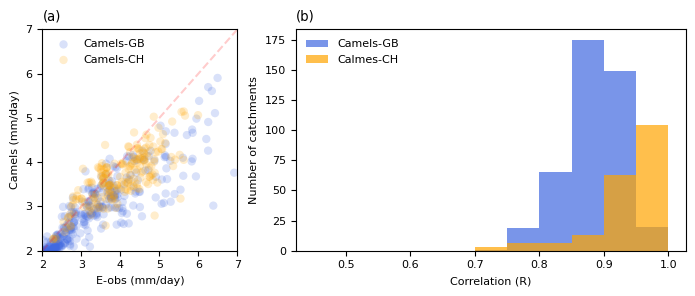

In [67]:
plt.rcParams.update({'font.size': 8})  # Change the 12 to your desired font size

# Example data
data_gb = correlation_gb**0.5
data_ch = correlation_ch**0.5

fig, axs = plt.subplots(1, 2, figsize=(7, 3),  gridspec_kw={'width_ratios': [1, 2]})

# Scatter plot:
x_values_ch = prec_mean_df_ch['EOBS']
y_values_ch = prec_mean_df_ch['Camels']

x_values_gb = prec_mean_df_gb['EOBS']
y_values_gb = prec_mean_df_gb['Camels']

# Add the line of equality in red dashed
axs[0].plot([2, 7], [2, 7], color='red', linestyle='--',  alpha=0.2)

# Create a scatter plot with limits and transparency
sns.scatterplot(x=x_values_gb, y=y_values_gb, color='royalblue', alpha=0.2, ax = axs[0], label='Camels-GB', edgecolor='none')
sns.scatterplot(x=x_values_ch, y=y_values_ch, color='orange', alpha=0.2, ax = axs[0], edgecolor='none', label='Camels-CH')


# Set x and y axis limits
axs[0].set_xlim([2, 7])  # Replace xmin and xmax with your desired limits
axs[0].set_ylim([2, 7])  # Replace ymin and ymax with your desired limits

axs[0].set_ylabel("Camels (mm/day)")
axs[0].set_xlabel("E-obs (mm/day)")


# Create a histogram with custom bin edges
bin_edges = [0.45,0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
sns.histplot(data_gb, bins=bin_edges, kde=False, ax=axs[1], palette=['royalblue'], alpha=.7, label='Camels-GB', linewidth = 0)
sns.histplot(data_ch, bins=bin_edges, kde=False, ax=axs[1], palette=['orange'], alpha=.7, label='Calmes-CH', linewidth = 0)

# Set the labels
axs[1].set_ylabel("Number of catchments")
axs[1].set_xlabel("Correlation (R)")

# Legend for the second subplot
axs[0].legend(frameon=False)
axs[1].legend(frameon=False)

# Title and labels
axs[0].set_title('(a)', loc="left")
axs[1].set_title('(b)', loc="left")

fig.tight_layout()

fig.savefig('results/meteo_forc_val.png', dpi=300,  bbox_inches='tight')

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


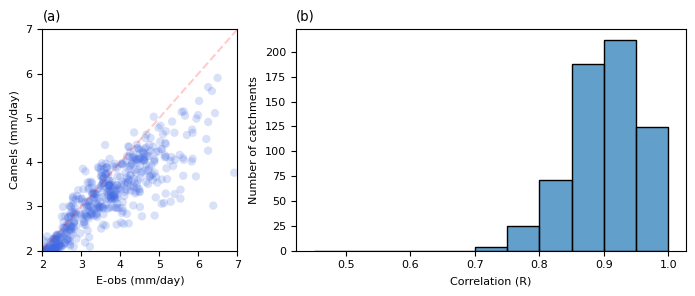

In [40]:
plt.rcParams.update({'font.size': 8})  # Change the 12 to your desired font size

# Example data
data = correlation_df**0.5

fig, axs = plt.subplots(1, 2, figsize=(7, 3),  gridspec_kw={'width_ratios': [1, 2]})

# Scatter plot:
x_values = prec_mean_df['EOBS']
y_values = prec_mean_df['Camels']
# Add the line of equality in red dashed
axs[0].plot([2, 7], [2, 7], color='red', linestyle='--',  alpha=0.2)

# Create a scatter plot with limits and transparency
sns.scatterplot(x=x_values, y=y_values, color='royalblue', alpha=0.2, ax = axs[0], edgecolor='none')

# Set x and y axis limits
axs[0].set_xlim([2, 7])  # Replace xmin and xmax with your desired limits
axs[0].set_ylim([2, 7])  # Replace ymin and ymax with your desired limits

axs[0].set_ylabel("Camels (mm/day)")
axs[0].set_xlabel("E-obs (mm/day)")


# Create a histogram with custom bin edges
bin_edges = [0.45,0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
sns.histplot(data, bins=bin_edges, kde=False, ax=axs[1], color='blue', alpha=.7)

# Set the labels
axs[1].set_ylabel("Number of catchments")
axs[1].set_xlabel("Correlation (R)")

# Legend for the second subplot
axs[1].legend(frameon=False)

# Title and labels
axs[0].set_title('(a)', loc="left")
axs[1].set_title('(b)', loc="left")

fig.tight_layout()

fig.savefig('results/meteo_forc_val_together.png', dpi=300,  bbox_inches='tight')

plt.show()

# Validation of number of reservoirs
## Import data

### Network information

In [5]:
network_EU = pd.read_excel("data/streamflow/estreams_gauging_stations.xlsx")
network_EU.set_index("new_code", inplace = True)

network_EU

,code,name,river,area,elev,lon,lat,country,degimpact,lake,num_reservoir,RE,remark,region
new_code,,,,,,,,,,,,,,
AT00001,200014,Bangs,Rhein,4647.9,420,9.534835,47.273748,AT,s,NaN,NaN,NaN,NaN,NaN
AT00002,200048,Schruns (Vonbunweg),Litz,102.0,673,9.913677,47.080301,AT,l,NaN,NaN,NaN,NaN,NaN
AT00003,231662,Loruens-Aeule,Ill,535.2,579,9.847765,47.132821,AT,s,NaN,NaN,NaN,NaN,NaN
AT00004,200592,Kloesterle (OEBB),Alfenz,66.6,1014,10.061843,47.128994,AT,s,NaN,NaN,NaN,NaN,NaN
AT00005,200097,Buers (Bruecke L82),Alvier,72.2,564,9.802668,47.150770,AT,s,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DE02106,5752400000,Hachelbich,Wipper,524.0,NaN,10.973285,51.347098,DE,NaN,NaN,NaN,NaN,NaN,TH
DE02107,5752500000,Bleicherode,Bode,104.0,NaN,10.592766,51.450407,DE,NaN,NaN,NaN,NaN,NaN,TH
DE02108,5754000000,Sundhausen,Helme,200.6,NaN,10.809725,51.467735,DE,NaN,NaN,NaN,NaN,NaN,TH


### Catchment boundaries

In [6]:
catchment_boundaries = gpd.read_file('data/shapefiles/estreams_catchments.shp')
catchment_boundaries

,id,area_km2,outlet_lat,outlet_lng,area_offic,area_calc,Code,basin_id,label_area,name,layer,path,geometry
0,DE01945,"144,000",50.937000,6.963000,144232,144432.885,DE01945,DE01945,0,BundespegelKoeln,None,None,"POLYGON Z ((7.96208 46.53708 0.00000, 7.96625 ..."
1,DE01946,"148,000",51.226000,6.770000,147680,147934.665,DE01946,DE01946,0,BundespegelDuesseldorf,None,None,"POLYGON Z ((7.96208 46.53708 0.00000, 7.96625 ..."
2,DE01947,"144,000",50.937000,6.963000,144232,144432.885,DE01947,DE01947,0,BundespegelKoeln,None,None,"POLYGON Z ((7.96208 46.53708 0.00000, 7.96625 ..."
3,DE01948,"148,000",51.226000,6.770000,147680,147934.665,DE01948,DE01948,0,BundespegelDuesseldorf,None,None,"POLYGON Z ((7.96208 46.53708 0.00000, 7.96625 ..."
4,DE01949,"159,000",51.757000,6.395000,159300,159352.653,DE01949,DE01949,0,BundespegelRees,None,None,"POLYGON Z ((7.96208 46.53708 0.00000, 7.96625 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15009,NL00015,148,51.812000,4.566000,None,148.000,NL00015,NL00015,888,Puttershoek,Catchment_Boundaries_NL_Merge,C:\Users\nascimth\Documents\Thiago\Eawag\Pytho...,"POLYGON Z ((4.49041 51.82958 0.00000, 4.49041 ..."
15010,NL00016,9500,51.350000,4.251000,None,9500.000,NL00016,NL00016,4,Schaar van Ouden Doel,Catchment_Boundaries_NL_Merge,C:\Users\nascimth\Documents\Thiago\Eawag\Pytho...,"POLYGON Z ((4.18958 51.29875 0.00000, 4.18958 ..."
15011,NL00017,21300,50.830000,5.697000,None,21300.000,NL00017,NL00017,4,Sint Pieter noord,Catchment_Boundaries_NL_Merge,C:\Users\nascimth\Documents\Thiago\Eawag\Pytho...,"POLYGON Z ((4.45041 49.91875 0.00000, 4.45041 ..."
15012,NL00014,3229,52.342353,6.103294,None,3229.000,NL00014,NL00014,6,Olst,Catchment_Boundaries_NL_Merge,C:\Users\nascimth\Documents\Thiago\Eawag\Pytho...,"POLYGON Z ((6.60946 52.15346 0.00000, 6.60837 ..."


### Reservoirs from Portugal

In [7]:
reservoirs_PT_sniamb = gpd.read_file('data/shapefiles/AtAgua_Agsup_ALB_NET_Project_PC.shp')
reservoirs_PT_sniamb

,id,albufeira,lagua,bacia,distrito,concelho,freguesia,adren_bara,adrenp_bar,altmax_bac,...,cc_npa,supinundnp,tresid,coeficreg,poa,rhidro_cod,escadaspei,aespanha,observacoe,geometry
0,190.0,Almourol (prevista),RIO TEJO,TEJO,SANTARÉM,VILA NOVA DA BARQUINHA,PRAIA DO RIBATEJO,67483.64,1979.06,676.0,...,0.00,1800.0,0.0,0.0,None,None,N,N,None,POINT (-21562.586 -22850.435)
1,191.0,Alqueva,RIO GUADIANA,GUADIANA,BEJA,MOURA,MOURA (SÃO JOÃO BAPTISTA),55289.00,53912.39,1580.0,...,2.00,25000.0,0.0,0.0,None,24M/07A,None,S,None,POINT (55867.042 -163107.708)
2,10.0,Alto Ceira,RIO CEIRA,MONDEGO,COIMBRA,PAMPILHOSA DA SERRA,FAJÃO,24.04,24.05,1403.0,...,1.50,110.8,90.0,0.0,None,12J/01AE,N,N,Esta barragem faz parte do complexo hidroeléct...,POINT (24430.374 57948.677)
3,38.0,Alto Cávado,RIO CÁVADO,CÁVADO/RIBEIRAS COSTEIRAS,VILA REAL,MONTALEGRE,SEZELHE,99.15,99.16,1515.0,...,5.00,50.0,0.0,0.0,None,03J/02AE,N,S,None,POINT (21227.076 237063.462)
4,83.0,Alto Lindoso,RIO LIMA,LIMA,VIANA DO CASTELO,ARCOS DE VALDEVEZ,SOAJO,1510.93,1510.94,1516.0,...,1.00,1072.0,0.0,0.0,None,02H/01A,N,S,None,POINT (-5778.862 244747.350)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,69.0,Vigia,RIBEIRA DO VALE DO VASCO,GUADIANA,ÉVORA,REDONDO,MONTOITO,125.32,125.33,363.0,...,2.25,262.0,0.0,0.0,None,22L/01A,N,N,None,POINT (45864.108 -125337.620)
232,124.0,Vila Seca,RIO CORGO,DOURO,VILA REAL,VILA REAL,ADOUFE,118.02,118.02,1308.0,...,0.00,0.0,0.0,0.0,None,None,None,N,None,POINT (35219.879 186210.961)
233,41.0,Vilar-Tabuaço,RIO TÁVORA,DOURO,VISEU,SERNANCELHE,FONTE ARCADA,357.39,348.70,982.0,...,3.00,670.0,0.0,0.0,None,08L/01A,N,N,None,POINT (50345.263 146628.640)
234,51.0,Vilarinho das Furnas,RIO HOMEM,CÁVADO/RIBEIRAS COSTEIRAS,BRAGA,TERRAS DE BOURO,CAMPO DO GERÊS,58.51,58.52,1513.0,...,0.50,346.0,0.0,0.0,None,03H/01A,N,S,None,POINT (-6376.578 232665.924)


### Number of dams and reservoirs (EStreams)

In [8]:
hydrology_df = pd.read_csv("data/hydrology/estreams_hydrology_attributes.csv")
hydrology_df.set_index("basin_id", inplace = True)

hydrology_df

,dam_num,res_num,dam_yr_first,dam_yr_last,res_tot_sto,lakes_num,lakes_tot_area,lakes_tot_vol
basin_id,,,,,,,,
AT00001,23.0,10.0,1954.0,1968.0,537.9,10.0,6.62,542.33
AT00002,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN
AT00003,4.0,4.0,NaN,NaN,NaN,3.0,1.46,12.91
AT00004,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN
AT00005,1.0,1.0,NaN,NaN,NaN,1.0,0.89,8.27
...,...,...,...,...,...,...,...,...
UAGR017,0.0,0.0,NaN,NaN,NaN,1.0,1.43,16.43
UAGR018,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN
UAGR019,0.0,0.0,NaN,NaN,NaN,1.0,0.31,1.54


In [9]:
# Filter the index based on whether it contains the character
hydrology_df_PT = hydrology_df[hydrology_df.index.str.contains('PT')]
hydrology_df_PT

,dam_num,res_num,dam_yr_first,dam_yr_last,res_tot_sto,lakes_num,lakes_tot_area,lakes_tot_vol
basin_id,,,,,,,,
PT00001,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN
PT00002,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN
PT00003,4.0,4.0,1981.0,1981.0,450.0,3.0,12.21,456.49
PT00004,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN
PT00005,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...
PT00276,1.0,1.0,1965.0,1965.0,99.8,1.0,5.66,99.80
PT00277,1.0,1.0,NaN,NaN,NaN,0.0,NaN,NaN
PT00278,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN


In [10]:
# Filter the index based on whether it contains the character
hydrology_df_CH = hydrology_df[hydrology_df.index.str.contains('CH')]
hydrology_df_CH

,dam_num,res_num,dam_yr_first,dam_yr_last,res_tot_sto,lakes_num,lakes_tot_area,lakes_tot_vol
basin_id,,,,,,,,
CH00001,37.0,21.0,1957.0,1974.0,1107.2,10.0,7.60,1110.73
CH00002,21.0,13.0,1957.0,1967.0,648.6,6.0,4.34,649.61
CH00003,20.0,13.0,1920.0,1969.0,566.2,36.0,403.42,10123.84
CH00004,16.0,9.0,1947.0,1960.0,101.0,15.0,167.54,14675.96
CH00005,5.0,5.0,1929.0,1953.0,203.0,6.0,5.13,206.95
...,...,...,...,...,...,...,...,...
CH00294,18.0,14.0,1921.0,1953.0,136.8,12.0,3.88,144.80
CH00295,0.0,0.0,NaN,NaN,NaN,1.0,16.88,754.58
CH00296,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN


In [11]:
# Filter the index based on whether it contains the character
hydrology_df_GB = hydrology_df[hydrology_df.index.str.contains('GB')]
hydrology_df_GB

,dam_num,res_num,dam_yr_first,dam_yr_last,res_tot_sto,lakes_num,lakes_tot_area,lakes_tot_vol
basin_id,,,,,,,,
GB00001,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN
GB00002,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN
GB00003,0.0,0.0,NaN,NaN,NaN,3.0,4.89,20.07
GB00004,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN
GB00005,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...
GB00667,0.0,0.0,NaN,NaN,NaN,3.0,7.68,106.25
GB00668,0.0,0.0,NaN,NaN,NaN,3.0,0.48,1.46
GB00669,0.0,0.0,NaN,NaN,NaN,14.0,13.06,128.01


### Number of dams and reservoirs from camels-ch

In [12]:
camels_ch = pd.read_csv("data/hydrology/CAMELS_CH_humaninfluence_attributes.csv", sep = ";", skiprows=1)

camels_ch

,gauge_id,n_inhabitants,dens_inhabitants,hp_count,hp_qturb,hp_inst_turb,hp_max_power,num_reservoir,reservoir_cap,reservoir_he,reservoir_fs,reservoir_irr,reservoir_nousedata,reservoir_year_first,reservoir_year_last
0,2004,124387,174.529,0,0.00,0.00,0.00,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2007,10091,48.213,0,0.00,0.00,0.00,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2009,342692,65.407,33,408.24,3286.43,3131.05,32,1228703.0,0.999,0.0,0.001,0.0,1914.0,1989.0
3,2011,174543,51.756,17,147.42,852.13,823.35,20,676429.0,0.998,0.0,0.002,0.0,1927.0,1989.0
4,2014,202866,128.112,9,368.55,1814.52,1858.18,9,328210.0,1.000,0.0,0.000,0.0,1910.0,2015.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326,6007,57538,37.572,0,0.00,0.00,0.00,1,200.0,1.000,0.0,0.000,0.0,2010.0,2010.0
327,6008,36597,159.325,0,0.00,0.00,0.00,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
328,6009,1648,13.553,0,0.00,0.00,0.00,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
329,6010,10357,172.043,0,0.00,0.00,0.00,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


### Number of dams and reservoirs from camels-gb

In [13]:
camels_gb = pd.read_csv("data/hydrology/CAMELS_GB_humaninfluence_attributes.csv", sep = ",", skiprows=0)

camels_gb

,gauge_id,benchmark_catch,surfacewater_abs,groundwater_abs,discharges,abs_agriculture_perc,abs_amenities_perc,abs_energy_perc,abs_environmental_perc,abs_industry_perc,...,reservoir_cap,reservoir_he,reservoir_nav,reservoir_drain,reservoir_wr,reservoir_fs,reservoir_env,reservoir_nousedata,reservoir_year_first,reservoir_year_last
0,10002,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10003,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1001,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11500,0.0,0.0,0.0,0.0,0.0,0.0,100.0,NaN,NaN
3,101002,N,0.006,0.023,0.018,18.92,0.0,0.0,0.0,18.29,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,101005,N,0.001,0.015,0.053,11.27,0.0,0.0,0.0,0.22,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,95001,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
667,96001,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
668,96002,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
669,96004,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Reproject to projected coordinates system

In [14]:
# Here you can check the crs of the datasets:
print("CRS of catchment_boundaries:", catchment_boundaries.crs)
print("CRS of GeoDAR_v11_dams:", reservoirs_PT_sniamb.crs)

CRS of catchment_boundaries: epsg:4326
CRS of GeoDAR_v11_dams: epsg:3763


In [15]:
# Define the target CRS to ETRS89 LAEA (3035)
target_crs = 'EPSG:4326'  

# Reproject the GeoDataFrame to the target CRS
reservoirs_PT_sniamb_reprojected = reservoirs_PT_sniamb.to_crs(target_crs)

## Intersection areas

In [16]:
# Here we use utils.count_geometries_in_polygons function
hydrology_df_PT["res_num_sniamb"] = count_geometries_in_polygons(reservoirs_PT_sniamb_reprojected, catchment_boundaries, "basin_id", new_column="dam_num")

In [17]:
hydrology_df_PT

,dam_num,res_num,dam_yr_first,dam_yr_last,res_tot_sto,lakes_num,lakes_tot_area,lakes_tot_vol,res_num_sniamb
basin_id,,,,,,,,,
PT00001,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0
PT00002,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0
PT00003,4.0,4.0,1981.0,1981.0,450.0,3.0,12.21,456.49,6.0
PT00004,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0
PT00005,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...
PT00276,1.0,1.0,1965.0,1965.0,99.8,1.0,5.66,99.80,2.0
PT00277,1.0,1.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0
PT00278,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0


In [19]:
hydrology_df_PT["area"] = network_EU.area
hydrology_df_PT

,dam_num,res_num,dam_yr_first,dam_yr_last,res_tot_sto,lakes_num,lakes_tot_area,lakes_tot_vol,res_num_sniamb,area
basin_id,,,,,,,,,,
PT00001,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,2.60
PT00002,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,608.49
PT00003,4.0,4.0,1981.0,1981.0,450.0,3.0,12.21,456.49,6.0,3072.41
PT00004,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,169.84
PT00005,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,204.08
...,...,...,...,...,...,...,...,...,...,...
PT00276,1.0,1.0,1965.0,1965.0,99.8,1.0,5.66,99.80,2.0,358.35
PT00277,1.0,1.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,478.54
PT00278,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN


In [20]:
## Here we exclude the catchments that encompass areas outside Portugal (areas above 10,000 km2)
hydrology_df_PT_filtered = hydrology_df_PT[hydrology_df_PT.area < 10000]
hydrology_df_PT_filtered

,dam_num,res_num,dam_yr_first,dam_yr_last,res_tot_sto,lakes_num,lakes_tot_area,lakes_tot_vol,res_num_sniamb,area
basin_id,,,,,,,,,,
PT00001,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,2.60
PT00002,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,608.49
PT00003,4.0,4.0,1981.0,1981.0,450.0,3.0,12.21,456.49,6.0,3072.41
PT00004,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,169.84
PT00005,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,204.08
...,...,...,...,...,...,...,...,...,...,...
PT00273,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,51.39
PT00274,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,38.61
PT00276,1.0,1.0,1965.0,1965.0,99.8,1.0,5.66,99.80,2.0,358.35


In [21]:
hydrology_df_PT_res = hydrology_df_PT_filtered.loc[:, [ "res_num", "res_num_sniamb"]]
hydrology_df_PT_res

,res_num,res_num_sniamb
basin_id,,
PT00001,0.0,0.0
PT00002,0.0,0.0
PT00003,4.0,6.0
PT00004,0.0,0.0
PT00005,0.0,0.0
...,...,...
PT00273,0.0,0.0
PT00274,0.0,0.0
PT00276,1.0,2.0


In [28]:
hydrology_df_PT_res.corr()

,res_num,res_num_sniamb
res_num,1.000000,0.873841
res_num_sniamb,0.873841,1.000000


## Switzerland

In [29]:
# Filter the index based on whether it contains the character
network_CH = network_EU[network_EU.index.str.contains('CH')]
network_CH

,code,name,river,area,elev,lon,lat,country,degimpact,lake,num_reservoir,RE,remark,region
new_code,,,,,,,,,,,,,,
CH00001,2009,Porte_du_Scex,Rhône,5239.4,377,6.89,46.35,CH,NaN,NaN,32.0,NaN,NaN,NaN
CH00002,2011,Sion,Rhône,3372.4,499,7.36,46.22,CH,NaN,NaN,20.0,NaN,NaN,NaN
CH00003,2016,Brugg,Aare,11681.3,341,8.19,47.48,CH,NaN,NaN,18.0,NaN,NaN,NaN
CH00004,2018,Mellingen,Reuss,3385.8,349,8.27,47.42,CH,NaN,NaN,11.0,NaN,NaN,NaN
CH00005,2019,Brienzwiler,Aare,555.2,587,8.09,46.75,CH,NaN,NaN,7.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CH00294,6007,Candoglia,Fiume_Toce,1531.4,198,8.42,45.97,CH,NaN,NaN,1.0,NaN,NaN,NaN
CH00295,6008,Gravellona,Torrente_Strona,229.7,211,8.43,45.93,CH,NaN,NaN,0.0,NaN,NaN,NaN
CH00296,6009,Santino,Torrente_San_Bernardino,121.6,254,8.53,45.96,CH,NaN,NaN,0.0,NaN,NaN,NaN


In [30]:
camels_ch.set_index("gauge_id", inplace = True)
camels_ch

,n_inhabitants,dens_inhabitants,hp_count,hp_qturb,hp_inst_turb,hp_max_power,num_reservoir,reservoir_cap,reservoir_he,reservoir_fs,reservoir_irr,reservoir_nousedata,reservoir_year_first,reservoir_year_last
gauge_id,,,,,,,,,,,,,,
2004,124387,174.529,0,0.00,0.00,0.00,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2007,10091,48.213,0,0.00,0.00,0.00,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2009,342692,65.407,33,408.24,3286.43,3131.05,32,1228703.0,0.999,0.0,0.001,0.0,1914.0,1989.0
2011,174543,51.756,17,147.42,852.13,823.35,20,676429.0,0.998,0.0,0.002,0.0,1927.0,1989.0
2014,202866,128.112,9,368.55,1814.52,1858.18,9,328210.0,1.000,0.0,0.000,0.0,1910.0,2015.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6007,57538,37.572,0,0.00,0.00,0.00,1,200.0,1.000,0.0,0.000,0.0,2010.0,2010.0
6008,36597,159.325,0,0.00,0.00,0.00,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
6009,1648,13.553,0,0.00,0.00,0.00,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
# We need to change the columns names from Camels to match the EStreams:
# We need to convert the code to int
network_CH.code = network_CH.code.astype(int)

# Now we create  a dictionary with the values:
code_dict = network_CH['code'].to_dict()

# Now we can invert the dictionary:
inverted_code_dict = {v: k for k, v in code_dict.items()}

# Add a new column to the DataFrame based on the dictionary and index
camels_ch['new_code'] = camels_ch.index.map(inverted_code_dict)

In [32]:
# Drop rows with NaN values in column 'B'
camels_ch = camels_ch.dropna(subset=['new_code'])
camels_ch.reset_index(inplace = True)
camels_ch.set_index("new_code", inplace = True)
camels_ch

,gauge_id,n_inhabitants,dens_inhabitants,hp_count,hp_qturb,hp_inst_turb,hp_max_power,num_reservoir,reservoir_cap,reservoir_he,reservoir_fs,reservoir_irr,reservoir_nousedata,reservoir_year_first,reservoir_year_last
new_code,,,,,,,,,,,,,,,
CH00001,2009,342692,65.407,33,408.24,3286.43,3131.05,32,1228703.0,0.999,0.0,0.001,0.0,1914.0,1989.0
CH00002,2011,174543,51.756,17,147.42,852.13,823.35,20,676429.0,0.998,0.0,0.002,0.0,1927.0,1989.0
CH00003,2016,2376486,203.444,18,660.48,1506.80,1453.50,18,608560.0,1.000,0.0,0.000,0.0,1920.0,1973.0
CH00004,2018,676753,199.880,6,79.55,262.00,255.20,11,113349.0,1.000,0.0,0.000,0.0,1910.0,1975.0
CH00005,2019,7542,13.584,11,335.40,1308.80,1279.40,7,212650.0,1.000,0.0,0.000,0.0,1929.0,1958.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CH00294,6007,57538,37.572,0,0.00,0.00,0.00,1,200.0,1.000,0.0,0.000,0.0,2010.0,2010.0
CH00295,6008,36597,159.325,0,0.00,0.00,0.00,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
CH00296,6009,1648,13.553,0,0.00,0.00,0.00,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
hydrology_df_CH["res_num_camels"] = camels_ch["num_reservoir"]
hydrology_df_CH

,dam_num,res_num,dam_yr_first,dam_yr_last,res_tot_sto,lakes_num,lakes_tot_area,lakes_tot_vol,res_num_camels
basin_id,,,,,,,,,
CH00001,37.0,21.0,1957.0,1974.0,1107.2,10.0,7.60,1110.73,32
CH00002,21.0,13.0,1957.0,1967.0,648.6,6.0,4.34,649.61,20
CH00003,20.0,13.0,1920.0,1969.0,566.2,36.0,403.42,10123.84,18
CH00004,16.0,9.0,1947.0,1960.0,101.0,15.0,167.54,14675.96,11
CH00005,5.0,5.0,1929.0,1953.0,203.0,6.0,5.13,206.95,7
...,...,...,...,...,...,...,...,...,...
CH00294,18.0,14.0,1921.0,1953.0,136.8,12.0,3.88,144.80,1
CH00295,0.0,0.0,NaN,NaN,NaN,1.0,16.88,754.58,0
CH00296,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0


In [34]:
hydrology_df_CH["res_num_camels"] = camels_ch["num_reservoir"]
hydrology_df_CH["area"] = network_CH.area

hydrology_df_CH

,dam_num,res_num,dam_yr_first,dam_yr_last,res_tot_sto,lakes_num,lakes_tot_area,lakes_tot_vol,res_num_camels,area
basin_id,,,,,,,,,,
CH00001,37.0,21.0,1957.0,1974.0,1107.2,10.0,7.60,1110.73,32,5239.4
CH00002,21.0,13.0,1957.0,1967.0,648.6,6.0,4.34,649.61,20,3372.4
CH00003,20.0,13.0,1920.0,1969.0,566.2,36.0,403.42,10123.84,18,11681.3
CH00004,16.0,9.0,1947.0,1960.0,101.0,15.0,167.54,14675.96,11,3385.8
CH00005,5.0,5.0,1929.0,1953.0,203.0,6.0,5.13,206.95,7,555.2
...,...,...,...,...,...,...,...,...,...,...
CH00294,18.0,14.0,1921.0,1953.0,136.8,12.0,3.88,144.80,1,1531.4
CH00295,0.0,0.0,NaN,NaN,NaN,1.0,16.88,754.58,0,229.7
CH00296,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0,121.6


In [35]:
hydrology_df_CH_filtered = hydrology_df_CH[hydrology_df_CH.area < 10000]
hydrology_df_CH_filtered

,dam_num,res_num,dam_yr_first,dam_yr_last,res_tot_sto,lakes_num,lakes_tot_area,lakes_tot_vol,res_num_camels,area
basin_id,,,,,,,,,,
CH00001,37.0,21.0,1957.0,1974.0,1107.2,10.0,7.60,1110.73,32,5239.4
CH00002,21.0,13.0,1957.0,1967.0,648.6,6.0,4.34,649.61,20,3372.4
CH00004,16.0,9.0,1947.0,1960.0,101.0,15.0,167.54,14675.96,11,3385.8
CH00005,5.0,5.0,1929.0,1953.0,203.0,6.0,5.13,206.95,7,555.2
CH00006,12.0,5.0,1920.0,1963.0,171.1,6.0,2.53,175.39,13,1517.5
...,...,...,...,...,...,...,...,...,...,...
CH00294,18.0,14.0,1921.0,1953.0,136.8,12.0,3.88,144.80,1,1531.4
CH00295,0.0,0.0,NaN,NaN,NaN,1.0,16.88,754.58,0,229.7
CH00296,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0,121.6


In [36]:
hydrology_df_CH_res = hydrology_df_CH_filtered.loc[:, ["res_num", "res_num_camels"]]
hydrology_df_CH_res

,res_num,res_num_camels
basin_id,,
CH00001,21.0,32
CH00002,13.0,20
CH00004,9.0,11
CH00005,5.0,7
CH00006,5.0,13
...,...,...
CH00294,14.0,1
CH00295,0.0,0
CH00296,0.0,0


In [37]:
hydrology_df_CH_res.corr()

,res_num,res_num_camels
res_num,1.000000,0.913187
res_num_camels,0.913187,1.000000


## Great Britain

In [38]:
# Filter the index based on whether it contains the character
network_GB = network_EU[network_EU.index.str.contains('GB')]
network_GB

,code,name,river,area,elev,lon,lat,country,degimpact,lake,num_reservoir,RE,remark,region
new_code,,,,,,,,,,,,,,
GB00001,10002,Ugie at Inverugie,Ugie at Inverugie,325.72,8.5,-1.83,57.53,GB,NaN,NaN,0.0,NaN,NaN,NaN
GB00002,10003,Ythan at Ellon,Ythan at Ellon,532.29,3.8,-2.09,57.36,GB,NaN,NaN,0.0,NaN,NaN,NaN
GB00003,1001,Wick at Tarroul,Wick at Tarroul,158.18,13,-3.27,58.48,GB,NaN,NaN,1.0,NaN,NaN,NaN
GB00004,101002,Medina at Shide,Medina at Shide,30.61,10.4,-1.29,50.69,GB,NaN,NaN,0.0,NaN,NaN,NaN
GB00005,101005,Eastern Yar at Budbridge,Eastern Yar at Budbridge,24.31,17.2,-1.25,50.65,GB,NaN,NaN,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GB00667,95001,Inver at Little Assynt,Inver at Little Assynt,138.47,60.3,-5.15,58.17,GB,NaN,NaN,0.0,NaN,NaN,NaN
GB00668,96001,Halladale at Halladale,Halladale at Halladale,193.72,23.2,-3.90,58.48,GB,NaN,NaN,0.0,NaN,NaN,NaN
GB00669,96002,Naver at Apigill,Naver at Apigill,474.01,5.1,-4.21,58.48,GB,NaN,NaN,0.0,NaN,NaN,NaN


In [39]:
camels_gb.set_index("gauge_id", inplace = True)
camels_gb

,benchmark_catch,surfacewater_abs,groundwater_abs,discharges,abs_agriculture_perc,abs_amenities_perc,abs_energy_perc,abs_environmental_perc,abs_industry_perc,abs_watersupply_perc,...,reservoir_cap,reservoir_he,reservoir_nav,reservoir_drain,reservoir_wr,reservoir_fs,reservoir_env,reservoir_nousedata,reservoir_year_first,reservoir_year_last
gauge_id,,,,,,,,,,,,,,,,,,,,,
10002,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10003,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11500,0.0,0.0,0.0,0.0,0.0,0.0,100.0,NaN,NaN
101002,N,0.006,0.023,0.018,18.92,0.0,0.0,0.0,18.29,62.79,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101005,N,0.001,0.015,0.053,11.27,0.0,0.0,0.0,0.22,88.51,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95001,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96001,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96002,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
# We need to change the columns names from Camels to match the EStreams:
# We need to convert the code to int
network_GB.code = network_GB.code.astype(int)

# Now we create  a dictionary with the values:
code_dict = network_GB['code'].to_dict()

# Now we can invert the dictionary:
inverted_code_dict = {v: k for k, v in code_dict.items()}

# Add a new column to the DataFrame based on the dictionary and index
camels_gb['new_code'] = camels_gb.index.map(inverted_code_dict)

In [41]:
camels_gb

,benchmark_catch,surfacewater_abs,groundwater_abs,discharges,abs_agriculture_perc,abs_amenities_perc,abs_energy_perc,abs_environmental_perc,abs_industry_perc,abs_watersupply_perc,...,reservoir_he,reservoir_nav,reservoir_drain,reservoir_wr,reservoir_fs,reservoir_env,reservoir_nousedata,reservoir_year_first,reservoir_year_last,new_code
gauge_id,,,,,,,,,,,,,,,,,,,,,
10002,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GB00001
10003,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GB00002
1001,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,100.0,NaN,NaN,GB00003
101002,N,0.006,0.023,0.018,18.92,0.0,0.0,0.0,18.29,62.79,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GB00004
101005,N,0.001,0.015,0.053,11.27,0.0,0.0,0.0,0.22,88.51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GB00005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95001,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GB00667
96001,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GB00668
96002,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GB00669


In [42]:
# Drop rows with NaN values in column 'B'
camels_gb = camels_gb.dropna(subset=['new_code'])
camels_gb.reset_index(inplace = True)
camels_gb.set_index("new_code", inplace = True)
camels_gb

,gauge_id,benchmark_catch,surfacewater_abs,groundwater_abs,discharges,abs_agriculture_perc,abs_amenities_perc,abs_energy_perc,abs_environmental_perc,abs_industry_perc,...,reservoir_cap,reservoir_he,reservoir_nav,reservoir_drain,reservoir_wr,reservoir_fs,reservoir_env,reservoir_nousedata,reservoir_year_first,reservoir_year_last
new_code,,,,,,,,,,,,,,,,,,,,,
GB00001,10002,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GB00002,10003,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GB00003,1001,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11500,0.0,0.0,0.0,0.0,0.0,0.0,100.0,NaN,NaN
GB00004,101002,N,0.006,0.023,0.018,18.92,0.0,0.0,0.0,18.29,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GB00005,101005,N,0.001,0.015,0.053,11.27,0.0,0.0,0.0,0.22,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GB00667,95001,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GB00668,96001,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GB00669,96002,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
hydrology_df_GB["res_num_camels"] = camels_gb["num_reservoir"]
hydrology_df_GB["area"] = network_GB.area

hydrology_df_GB

,dam_num,res_num,dam_yr_first,dam_yr_last,res_tot_sto,lakes_num,lakes_tot_area,lakes_tot_vol,res_num_camels,area
basin_id,,,,,,,,,,
GB00001,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0,325.72
GB00002,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0,532.29
GB00003,0.0,0.0,NaN,NaN,NaN,3.0,4.89,20.07,1,158.18
GB00004,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0,30.61
GB00005,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0,24.31
...,...,...,...,...,...,...,...,...,...,...
GB00667,0.0,0.0,NaN,NaN,NaN,3.0,7.68,106.25,0,138.47
GB00668,0.0,0.0,NaN,NaN,NaN,3.0,0.48,1.46,0,193.72
GB00669,0.0,0.0,NaN,NaN,NaN,14.0,13.06,128.01,0,474.01


In [44]:
hydrology_df_GB_filtered = hydrology_df_GB[hydrology_df_GB.area < 10000]
hydrology_df_GB_filtered

,dam_num,res_num,dam_yr_first,dam_yr_last,res_tot_sto,lakes_num,lakes_tot_area,lakes_tot_vol,res_num_camels,area
basin_id,,,,,,,,,,
GB00001,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0,325.72
GB00002,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0,532.29
GB00003,0.0,0.0,NaN,NaN,NaN,3.0,4.89,20.07,1,158.18
GB00004,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0,30.61
GB00005,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0,24.31
...,...,...,...,...,...,...,...,...,...,...
GB00667,0.0,0.0,NaN,NaN,NaN,3.0,7.68,106.25,0,138.47
GB00668,0.0,0.0,NaN,NaN,NaN,3.0,0.48,1.46,0,193.72
GB00669,0.0,0.0,NaN,NaN,NaN,14.0,13.06,128.01,0,474.01


In [45]:
hydrology_df_GB_res = hydrology_df_GB_filtered.loc[:, ["res_num", "res_num_camels"]]
hydrology_df_GB_res

,res_num,res_num_camels
basin_id,,
GB00001,0.0,0
GB00002,0.0,0
GB00003,0.0,1
GB00004,0.0,0
GB00005,0.0,0
...,...,...
GB00667,0.0,0
GB00668,0.0,0
GB00669,0.0,0


In [46]:
hydrology_df_GB_res.corr()

,res_num,res_num_camels
res_num,1.000000,0.736969
res_num_camels,0.736969,1.000000


## Make the plot:

In [49]:
# Correlation coefficients:
x_values_ch = hydrology_df_CH_res['res_num']
y_values_ch = hydrology_df_CH_res['res_num_camels']

x_values_gb = hydrology_df_GB_res['res_num']
y_values_gb = hydrology_df_GB_res['res_num_camels']

x_values_pt = hydrology_df_PT_res['res_num']
y_values_pt = hydrology_df_PT_res['res_num_sniamb']

r_value_ch = np.corrcoef(x_values_ch, y_values_ch)[0, 1]  # Calculate correlation coefficient
r_value_gb = np.corrcoef(x_values_gb, y_values_gb)[0, 1]  # Calculate correlation coefficient
r_value_pt = np.corrcoef(x_values_pt, y_values_pt)[0, 1]  # Calculate correlation coefficient

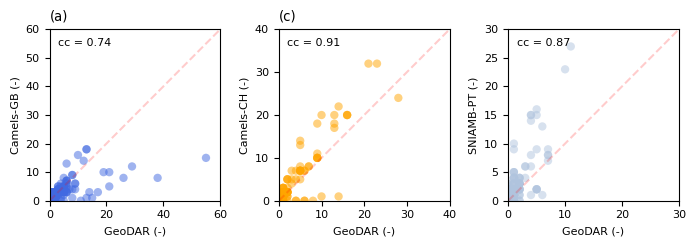

In [50]:
plt.rcParams.update({'font.size': 8})  # Change the 12 to your desired font size

fig, axs = plt.subplots(1, 3, figsize=(7, 2.5),  gridspec_kw={'width_ratios': [1, 1, 1]})

# Scatter plot:
# Add the line of equality in red dashed
axs[0].plot([0, 60], [0, 60], color='red', linestyle='--',  alpha=0.2)
axs[1].plot([0, 60], [0, 60], color='red', linestyle='--',  alpha=0.2)
axs[2].plot([0, 60], [0, 60], color='red', linestyle='--',  alpha=0.2)

# Create a scatter plot with limits and transparency
sns.scatterplot(x=x_values_ch, y=y_values_ch, color='orange', alpha=0.5, ax = axs[1], edgecolor='none')
sns.scatterplot(x=x_values_gb, y=y_values_gb, color='royalblue', alpha=0.5, ax = axs[0], edgecolor='none')
sns.scatterplot(x=x_values_pt, y=y_values_pt, color='lightsteelblue', alpha=0.5, ax = axs[2], edgecolor='none')

axs[0].annotate(f'cc = {r_value_gb:.2f}', xy=(0.05, 0.9), xycoords='axes fraction', fontsize=8)
axs[1].annotate(f'cc = {r_value_ch:.2f}', xy=(0.05, 0.9), xycoords='axes fraction', fontsize=8)
axs[2].annotate(f'cc = {r_value_pt:.2f}', xy=(0.05, 0.9), xycoords='axes fraction', fontsize=8)

# Set x and y axis limits
axs[0].set_xlim([0, 60])  # Replace xmin and xmax with your desired limits
axs[0].set_ylim([0, 60])  # Replace ymin and ymax with your desired limits
axs[1].set_xlim([0, 40])  # Replace xmin and xmax with your desired limits
axs[1].set_ylim([0, 40])  # Replace ymin and ymax with your desired limits
axs[2].set_xlim([0, 30])  # Replace xmin and xmax with your desired limits
axs[2].set_ylim([0, 30])  # Replace ymin and ymax with your desired limits

axs[0].set_ylabel("Camels-GB (-)")
axs[0].set_xlabel("GeoDAR (-)")

axs[1].set_ylabel("Camels-CH (-)")
axs[1].set_xlabel("GeoDAR (-)")

axs[2].set_ylabel("SNIAMB-PT (-)")
axs[2].set_xlabel("GeoDAR (-)")

# Title and labels
axs[0].set_title('(a)', loc="left")
axs[1].set_title('(b)', loc="left")
axs[1].set_title('(c)', loc="left")

fig.tight_layout()

fig.savefig('results/fig_num_reservoirs.png', dpi=300,  bbox_inches='tight')

plt.show()

## End